In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import pyarrow as pa
import pyarrow.parquet as pq

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator

!date
!whoami
!pwd

Wed Oct 29 23:51:48 PDT 2025
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# Show versions of Vivarium libraries

In [3]:
!pip list | grep vivarium

vivarium                                 3.4.12
vivarium_build_utils                     2.0.4
vivarium_cluster_tools                   2.1.17
vivarium_csu_alzheimers                  0.1.dev18+g43e997c.d20250808 /mnt/share/code/ndbs/vivarium_csu_alzheimers
vivarium_dependencies                    1.0.1
vivarium_gbd_access                      4.2.4
vivarium_helpers                         0.2.0                        /mnt/share/code/ndbs/vivarium_helpers/src
vivarium_inputs                          6.0.4
vivarium_public_health                   4.3.5


In [4]:
!pip freeze | grep vivarium

vivarium==3.4.12
vivarium_build_utils==2.0.4
vivarium_cluster_tools==2.1.17
-e git+https://github.com/ihmeuw/vivarium_csu_alzheimers.git@fc5ccf522118f76d1032f9ecf80b90ed4bef40c2#egg=vivarium_csu_alzheimers
vivarium_dependencies==1.0.1
vivarium_gbd_access==4.2.4
-e git+https://github.com/ihmeuw/vivarium_helpers.git@f9190d90327e2ef8c907cd8edf7bd0648d44d214#egg=vivarium_helpers
vivarium_inputs==6.0.4
vivarium_public_health==4.3.5


# V&V list

# Find data

 /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/united_states_of_america/2025_10_28_08_55_05/results/

In [5]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [6]:
# Results directory containing model 7.6 results for all locations
model_run_subdir = 'results/abie_consistent_model_test/united_states_of_america/2025_10_28_08_55_05/'
!ls -halt $model_run_subdir/results

total 60M
drwxrwsr-x 5 abie IHME-Simulationscience 4.5K Oct 28 09:19 ..
drwxrwsr-x 2 abie IHME-Simulationscience 6.5K Oct 28 09:17 .
-rw-rw-r-- 1 abie IHME-Simulationscience  17M Oct 28 09:17 ylds.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience 8.2M Oct 28 09:17 ylls.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience 5.2M Oct 28 09:17 person_time_treatment.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience 512K Oct 28 09:17 counts_newly_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience 794K Oct 28 09:17 person_time_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience 1.4M Oct 28 09:17 deaths.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience 4.1M Oct 28 09:17 person_time_ever_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience 841K Oct 28 09:17 counts_new_simulants.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience 406K Oct 28 09:17 counts_bbbm_tests.parquet
-rw-rw-r-- 1 abie IHME-Simulationscience 2.4M Oct 28 09:17 counts_

In [7]:
!ls $model_run_subdir

__pycache__		   keyspace.yaml	     requirements.txt
branches.yaml		   logs			     results
finished_sim_metadata.csv  model_specification.yaml  settings.py


In [8]:
!ls artifacts/model8.3

 brazil.hdf    japan.hdf			 united_kingdom.hdf
 china.hdf     spain.hdf			 united_states_of_america.hdf
 germany.hdf   sweden.hdf
 israel.hdf   'taiwan_(province_of_china).hdf'


In [9]:
locations = [
    'United States of America',
    'Brazil',
    'China',
    'Germany',
    'Israel',
    'Japan',
    'Spain',
    'Sweden',
    'Taiwan (Province of China)',
    'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations}| {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# Select a subset of locations to draw plots for
locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

artifact_model_number = '8.3' # Artifacts are stored here
run_subdirectories = [
    model_run_subdir,
]
run_dirs = [project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# # Option 1: One results directory per location
# location_to_results_dir = {
#     loc: path for loc, path in zip(locations, results_dirs)}

# Option 2: All locations in one results directory
location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{artifact_model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
artifact_path_to_location = {path: loc for loc, path in location_to_artifact_path.items()}
# artifact_path_to_location = {project_dir + subpath: loc for subpath, loc in zip(artifact_subpaths, locations)}
artifact_path_to_location

{'/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf': 'United States of America',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/brazil.hdf': 'Brazil',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf': 'China',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/germany.hdf': 'Germany',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/israel.hdf': 'Israel',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/japan.hdf': 'Japan',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/spain.hdf': 'Spain',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf': 'Sweden',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/taiwan_(province_of

In [10]:
results_dirs

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/united_states_of_america/2025_10_28_08_55_05/results/']

In [11]:
d = results_dirs[0]
!ls $d

counts_baseline_tests_among_eligible.parquet
counts_bbbm_tests.parquet
counts_new_simulants.parquet
counts_newly_eligible_for_bbbm_testing.parquet
deaths.parquet
person_time_alzheimers_disease_and_other_dementias.parquet
person_time_eligible_for_bbbm_testing.parquet
person_time_ever_eligible_for_bbbm_testing.parquet
person_time_treatment.parquet
transition_count_alzheimers_disease_and_other_dementias.parquet
transition_count_treatment.parquet
ylds.parquet
ylls.parquet


# Get list of draws and draw columns from `keyspace.yaml`, and reduce to a subset of draws to save memory and time

In [12]:
with open(run_dirs[0] + 'keyspace.yaml', 'r') as keyspace_file:
    keyspace = yaml.safe_load(keyspace_file)
draws = keyspace['input_draw']
print(draws)

[457, 169, 323, 392, 346]


In [13]:
# I ended up never actually using this -- I just used all the draws
draws = sorted(draws[:10]) # reduce to a subset of draws to save memory, and sort
draw_cols = [f'draw_{i}' for i in draws]
print(draw_cols)

['draw_169', 'draw_323', 'draw_346', 'draw_392', 'draw_457']


# Define some ordered Categorical dtypes, and convert years to ints

In [14]:
# Order locations lexicographically
all_locations = [
    'United States of America',
    'Brazil',
    'China',
    'Germany',
    'Israel',
    'Japan',
    'Spain',
    'Sweden',
    'Taiwan (Province of China)',
    'United Kingdom',
]
location_dtype = pd.CategoricalDtype(sorted(all_locations), ordered=True)

# Order years chronologically (for some reason years are strings in the output)
# years = [str(year) for year in range(2025, 2101)]
# year_dtype = pd.CategoricalDtype(years, ordered=True)
# int16 ranges from -32768 to 32767 (I think), which is sufficient to
# represent all years 2025-2100. uint8 only goes from 0 to 255, which is
# too small.
year_dtype = 'int16'

# Order age groups chronologically
age_groups = [f'{age}_to_{age + 4}' for age in range(25, 95, 5)] + ['95_plus']
age_group_dtype = pd.CategoricalDtype(age_groups, ordered=True)

# Order scenarios by complexity
scenarios = ['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
scenario_dtype = pd.CategoricalDtype(scenarios, ordered=True)

colname_to_dtype = {
    'location': location_dtype,
    'event_year': year_dtype,
    'age_group': age_group_dtype,
    'scenario': scenario_dtype,
}

# Load one artifact and define age bins

In [15]:
usa_artifact_path = location_to_artifact_path['United States of America']
usa_art = Artifact(usa_artifact_path)
print(usa_art.load('metadata.locations'))
print(usa_art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		excess_mortality_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		disability_weight
		restrictions
		cause_specific_mortality_rate
	alzheimers_consistent
		population_incidence_any
		prevalence_any
		population_incidence_dementia
		excess_mortality_rate
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		ode_errors
		susceptible_to_bbbm_transition_count
		dementia_conditional_prevalence
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [16]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = usa_art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

age_group_id age_group_name  age_start  age_end age_group
4             10       25 to 29       25.0     30.0  25_to_29
5             11       30 to 34       30.0     35.0  30_to_34
6             12       35 to 39       35.0     40.0  35_to_39
7             13       40 to 44       40.0     45.0  40_to_44
8             14       45 to 49       45.0     50.0  45_to_49
9             15       50 to 54       50.0     55.0  50_to_54
10            16       55 to 59       55.0     60.0  55_to_59
11            17       60 to 64       60.0     65.0  60_to_64
12            18       65 to 69       65.0     70.0  65_to_69
13            19       70 to 74       70.0     75.0  70_to_74
14            20       75 to 79       75.0     80.0  75_to_79
15            30       80 to 84       80.0     85.0  80_to_84
16            31       85 to 89       85.0     90.0  85_to_89
17            32       90 to 94       90.0     95.0  90_to_94
18           235        95 plus       95.0    125.0   95_plus

In [17]:
age_bins.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19 entries, (6, '5 to 9', 5.0, 10.0) to (235, '95 plus', 95.0, 125.0)
Empty DataFrame


# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [18]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Load CSF and PET testing rates

In [19]:
# NOTE: Dropping level 1 of index because it is meaningless, containing
# all 0s: 
# https://github.com/ihmeuw/vivarium_csu_alzheimers/blob/7674a25da52e8b9ee23c0184a2e65c6f53aac335/src/vivarium_csu_alzheimers/data/loader.py#L487-L489
csf_rates = load_artifact_data('testing_rates.csf').droplevel(1)
pet_rates = load_artifact_data('testing_rates.pet').droplevel(1)
existing_test_rates = (
    pd.concat(
        {'csf': csf_rates, 'pet': pet_rates}, names=['test_type', 'location'])
    .rename_axis(columns='input_draw')
)
existing_test_rates

input_draw                              draw_0    draw_1    draw_2    draw_3  \
test_type location                                                             
csf       United States of America    0.086170  0.140511  0.102449  0.092320   
          Brazil                      0.105865  0.173411  0.126100  0.113509   
          China                       0.035023  0.057369  0.041717  0.037552   
          Germany                     0.148848  0.243818  0.177298  0.159596   
          Israel                      0.105865  0.173411  0.126100  0.113509   
          Japan                       0.105865  0.173411  0.126100  0.113509   
          Spain                       0.195811  0.320745  0.233237  0.209950   
          Sweden                      0.322372  0.528056  0.383988  0.345649   
          Taiwan (Province of China)  0.105865  0.173411  0.126100  0.113509   
          United Kingdom              0.075618  0.123865  0.090071  0.081078   
pet       United States of America    0.172089  0.196148  0.165458  0.088834   
          Brazil                      0.170942  0.194840  0.164355  0.088241   
          China                       0.069983  0.079767  0.067286  0.036126   
          Germany                     0.183562  0.209225  0.176489  0.094756   
          Israel                      0.170942  0.194840  0.164355  0.088241   
          Japan                       0.170942  0.194840  0.164355  0.088241   
          Spain                       0.297141  0.338682  0.285691  0.153386   
          Sweden                      0.051627  0.058844  0.049637  0.026650   
          Taiwan (Province of China)  0.170942  0.194840  0.164355  0.088241   
          United Kingdom              0.122757  0.139919  0.118027  0.063368   

input_draw                              draw_4    draw_5    draw_6    draw_7  \
test_type location                                                             
csf       United States of America    0.126445  0.062653  0.118921  0.087192   
          Brazil                      0.155928  0.076634  0.146575  0.107136   
          China                       0.051585  0.025353  0.048491  0.035443   
          Germany                     0.219236  0.107748  0.206087  0.150634   
          Israel                      0.155928  0.076634  0.146575  0.107136   
          Japan                       0.155928  0.076634  0.146575  0.107136   
          Spain                       0.288407  0.141744  0.271109  0.198161   
          Sweden                      0.474817  0.233359  0.446338  0.326240   
          Taiwan (Province of China)  0.155928  0.076634  0.146575  0.107136   
          United Kingdom              0.111377  0.054738  0.104697  0.076526   
pet       United States of America    0.164784  0.180419  0.178008  0.223862   
          Brazil                      0.163686  0.179216  0.176821  0.222370   
          China                       0.067012  0.073370  0.072390  0.091037   
          Germany                     0.175770  0.192447  0.189875  0.238786   
          Israel                      0.163686  0.179216  0.176821  0.222370   
          Japan                       0.163686  0.179216  0.176821  0.222370   
          Spain                       0.284528  0.311524  0.307361  0.386535   
          Sweden                      0.049435  0.054126  0.053402  0.067159   
          Taiwan (Province of China)  0.163686  0.179216  0.176821  0.222370   
          United Kingdom              0.117546  0.128699  0.126979  0.159688   

input_draw                              draw_8    draw_9  ...  draw_490  \
test_type location                                        ...             
csf       United States of America    0.096971  0.095522  ...  0.131668   
          Brazil                      0.119291  0.117490  ...  0.162419   
          China                       0.039465  0.038869  ...  0.053733   
          Germany                     0.167726  0.165193  ...  0.228364   
          Israel            

In [20]:
existing_test_rates.stack().rename('value').to_frame()

value
test_type location                 input_draw          
csf       United States of America draw_0      0.086170
                                   draw_1      0.140511
                                   draw_2      0.102449
                                   draw_3      0.092320
                                   draw_4      0.126445
...                                                 ...
pet       United Kingdom           draw_495    0.143989
                                   draw_496    0.129093
                                   draw_497    0.117380
                                   draw_498    0.107381
                                   draw_499    0.068556

[10000 rows x 1 columns]

# Define functions to load simulation output and summarize it for plotting

In [21]:
# Create an operator object
ops = VPHOperator()
ops.index_cols.append('location')

def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        # Pass None to skip filtering locations (when None, must also
        # pass assign_location=False or raw=True)
        location_to_artifact_path=location_to_artifact_path,
        colname_to_dtype=colname_to_dtype,
        drop_superfluous_cols=True, # drop redundant or empty columns
        # Sets the 'read_dictionary' key of kwargs, which is passed to
        # pyarrow.parquet.read_table()
        force_parquet_dictionaries=True,
        force_pandas_categoricals=True,
        aggregate_seeds=True,
        assign_location=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    if raw:
        drop_superfluous_cols = False
        force_parquet_dictionaries = False
        force_pandas_categoricals = False
        aggregate_seeds = False
        assign_location = False

    match location_to_results_dir:
        case {'all': _}:
            all_locations_together = True
        case _:
            all_locations_together = False
    
    if all_locations_together and assign_location and location_to_artifact_path is None:
        raise ValueError(
            "Must provide mapping of artifacts to locations  when" \
            " assign_location=True and all locations are in a single" \
            " results directory"
        )

    dfs = []
    for location, directory in results_dict.items():

        parquet_file_path = Path(directory) / f'{measure}.parquet'
        # Read the Parquet file's schema to get column names and data types
        parquet_schema = pq.read_schema(parquet_file_path)

        if (
            all_locations_together
            and location_to_artifact_path is not None
        ):
            if 'artifact_path' in parquet_schema.names:
                # Filter to locations in list
                location_filter = (
                    'artifact_path',
                    'in',
                    list(location_to_artifact_path.values()),
                )
                user_filters = kwargs.get('filters') # Defaults to None
                kwargs['filters'] = add_parquet_AND_filter(
                    location_filter, user_filters)
                # TODO: Change this to logging instead of printing
                print(location_filter)
            else:
                print("'artifact_path' column missing from parquet file."
                      " Not filtering locations.")

        if force_parquet_dictionaries:
            # Read all columns as dictionaries except those containing 
            # floating point values
            kwargs['read_dictionary'] = [
                col.name for col in parquet_schema
                if not pa.types.is_floating(col.type)]

        # Read the parquet file
        df = pd.read_parquet(parquet_file_path, **kwargs)

        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns (e.g., sub-entity)
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if colname_to_dtype is not None:
            # NOTE: If copy-on-write is enabled, copy keyword is ignored
            df = df.astype(
                # Must filter to avoid KeyError
                {c: dtype for c, dtype in colname_to_dtype.items() if c in df},
                copy=False
            )
        if force_pandas_categoricals:
            convert_to_categorical(
                df, exclude_cols=colname_to_dtype or (), inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if assign_location:
            if all_locations_together:
                # Invert the dictionary so we can map artifact paths to
                # locations
                # NOTE: Guaranteed not to be None because
                # assign_location is True
                artifact_path_to_location = {
                    path: loc for loc, path in location_to_artifact_path.items()}
                if 'artifact_path' in df:
                    df['location'] = df['artifact_path'].map(
                        artifact_path_to_location).astype(location_dtype)
                else:
                    # In case the engineers change the DataFrame format
                    # on us...
                    print("'artifact_path' column missing from DataFrame."
                          " Not assigning locations.")
            else:
                df['location'] = location
                df['location'] = df['location'].astype(location_dtype)
        dfs.append(df)
    df = pd.concat(dfs)
    return df

# # NOTE: This function is unnecessary because it does the same thing as
# # DataFrame.astype
# def convert_dtypes(df, colname_to_dtype, inplace=False):
#     if not inplace:
#         df = df.copy()
#     for colname, dtype in colname_to_dtype.items():
#         if colname in df:
#             df[colname] = df[colname].astype(dtype)

#     if not inplace:
#         return df
#     else:
#         return None

# TODO: Consider making certain columns ordered Categoricals
def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None
    
def add_parquet_AND_filter(new_filter, existing_filters):
    match existing_filters:
        case None:
            # No existing filters -- create a single AND group
            filters = [new_filter]
        case list([tuple((_, _, _)), *_]):
            # Existing filters consist of one AND group -- add the new filter
            filters = [new_filter, *existing_filters]
        case list([list([tuple((_, _, _)), *_]), *_]):
            # Add the filter to each AND group in the outer OR group
            filters = [[new_filter, *and_group] for and_group in existing_filters]
        case _:
            raise ValueError(f"Malformed parquet filter: {existing_filters}")
    # # Alternate version using isinstance()
    # if existing_filters is None:
    #     # No existing filters -- create a single AND group
    #     filters = [new_filter]
    # elif isinstance(existing_filters[0], tuple):
    #     # Existing filters consist of one AND group -- add the new filter
    #     filters = [new_filter, *existing_filters]
    # elif isinstance(existing_filters[0], list):
    #     # Add the filter to each AND group in the outer OR group
    #     filters = [[new_filter, *and_group] for and_group in existing_filters]
    # else:
    #     raise ValueError(f"Malformed parquet filter: {existing_filters}")
    return filters

# NOTE: Need to create ops before defining this function
def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

def print_memory_usage(df):
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB')


# Load baseline test counts

In [22]:
# On the first attempt, this resulted in an empty DataFrame. Using
# raw=True, I determined that the .groupby was failing because of NaNs
# in the sub_entity column, since dropna=True by default.
existing_tests = load_sim_output(
    'counts_baseline_tests_among_eligible',
    # location_to_artifact_path=None,
    # raw=True,
)
# Memory usage is almost 3 GB when loading without Categoricals
print_memory_usage(existing_tests)
existing_tests

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/germany.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/israel.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/japan.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/spain.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/taiwan_(province_of_china).hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/a

12.966223 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
647995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
647996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
647997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
647998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
647999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                  entity entity_type  event_year input_draw  \
0       baseline_testing     testing        2025        392   
1       baseline_testing     testing        2025        392   
2       baseline_testing     testing        2025        392   
3       baseline_testing     testing        2025        392   
4       baseline_testing     testing        2025        392   
...                  ...         ...         ...        ...   
647995  baseline_testing     testing        2060        346   
647996  baseline_testing     testing        2060        346   
647997  baseline_testing     testing        2060        346   
647998  baseline_testing     testing        2060        346   
647999  baseline_testing     testing        2060        346   

                                     measure                    scenario  \
0       counts_baseline_tests_among_eligible                    baseline   
1       counts_baseline_tests_among_eligible                    baseline   
2       counts_baseline_tests_among_eligible                    baseline   
3       counts_baseline_tests_among_eligible                    baseline   
4       counts_baseline_tests_among_eligible                    baseline   
...                                      ...                         ...   
647995  counts_baseline_tests_among_eligible  bbbm_testing_and_treatment   
647996  counts_baseline_tests_among_eligible  bbbm_testing_and_treatment   
647997  counts_baseline_tests_among_eligible  bbbm_testing_and_treatment   
647998  counts_baseline_tests_among_eligible  bbbm_testing_and_treatment   
647999  counts_baseline_tests_among_eligible  bbbm_testing_and_treatment   

           sex testing_state  value location  
0       Female    not_tested    0.0    Japan  
1       Female           csf    0.0    Japan  
2       Female           pet    0.0    Japan  
3       Female          bbbm    0.0    Japan  
4         Male    not_tested    0.0    Japan  
...        ...           ...    ...      ...  
647995  Female          bbbm    9.0    China  
647996    Male    not_tested   16.0    China  
647997    Male           csf    0.0    China  
647998    Male           pet    0.0    China  
647999    Male          bbbm    0.0    China  

[648000 rows x 12 columns]

In [23]:
# # Column doesn't exist when using simulate for one location instead of
# # psimulate for multpile locations
# existing_tests.artifact_path.unique()

In [24]:
existing_tests.location.unique()

['Japan', 'Sweden', 'Spain', 'United States of America', 'Germany', 'United Kingdom', 'Israel', 'Taiwan (Province of China)', 'Brazil', 'China']
Categories (10, object): ['Brazil' < 'China' < 'Germany' < 'Israel' ... 'Sweden' < 'Taiwan (Province of China)' < 'United Kingdom' < 'United States of America']

In [25]:
# Check memory usage -- loading it raw, it took up 2.1 GB
existing_tests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648000 entries, 0 to 647999
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   age_group      648000 non-null  category
 1   artifact_path  648000 non-null  category
 2   entity         648000 non-null  category
 3   entity_type    648000 non-null  category
 4   event_year     648000 non-null  int16   
 5   input_draw     648000 non-null  category
 6   measure        648000 non-null  category
 7   scenario       648000 non-null  category
 8   sex            648000 non-null  category
 9   testing_state  648000 non-null  category
 10  value          648000 non-null  float64 
 11  location       648000 non-null  category
dtypes: category(10), float64(1), int16(1)
memory usage: 12.4 MB


In [26]:
# See if there is only one measure, or more
existing_tests.measure.unique()

['counts_baseline_tests_among_eligible']
Categories (1, object): ['counts_baseline_tests_among_eligible']

In [27]:
# Check whether all values are integers -- yes
(existing_tests.value % 1).unique()

array([0.])

# Divide to calculate CSF/PET testing rates from sim

In [28]:
sim_test_rates = ops.ratio(
    existing_tests,
    existing_tests,
    strata = ['event_year'],
    numerator_broadcast='testing_state',
)
sim_test_rates

event_year  input_draw                    scenario  \
0            2025         169                    baseline   
1            2025         169                    baseline   
2            2025         169                    baseline   
3            2025         169                    baseline   
4            2025         169                    baseline   
...           ...         ...                         ...   
21595        2060         457  bbbm_testing_and_treatment   
21596        2060         457  bbbm_testing_and_treatment   
21597        2060         457  bbbm_testing_and_treatment   
21598        2060         457  bbbm_testing_and_treatment   
21599        2060         457  bbbm_testing_and_treatment   

                       location testing_state     value  \
0                        Brazil    not_tested  0.343773   
1                        Brazil           csf  0.078889   
2                        Brazil           pet  0.214655   
3                        Brazil          bbbm  0.362683   
4                         China    not_tested  0.393882   
...                         ...           ...       ...   
21595            United Kingdom          bbbm  0.527859   
21596  United States of America    not_tested  0.347503   
21597  United States of America           csf  0.098406   
21598  United States of America           pet  0.110521   
21599  United States of America          bbbm  0.443571   

                          numerator_measure  \
0      counts_baseline_tests_among_eligible   
1      counts_baseline_tests_among_eligible   
2      counts_baseline_tests_among_eligible   
3      counts_baseline_tests_among_eligible   
4      counts_baseline_tests_among_eligible   
...                                     ...   
21595  counts_baseline_tests_among_eligible   
21596  counts_baseline_tests_among_eligible   
21597  counts_baseline_tests_among_eligible   
21598  counts_baseline_tests_among_eligible   
21599  counts_baseline_tests_among_eligible   

                        denominator_measure  multiplier  
0      counts_baseline_tests_among_eligible           1  
1      counts_baseline_tests_among_eligible           1  
2      counts_baseline_tests_among_eligible           1  
3      counts_baseline_tests_among_eligible           1  
4      counts_baseline_tests_among_eligible           1  
...                                     ...         ...  
21595  counts_baseline_tests_among_eligible           1  
21596  counts_baseline_tests_among_eligible           1  
21597  counts_baseline_tests_among_eligible           1  
21598  counts_baseline_tests_among_eligible           1  
21599  counts_baseline_tests_among_eligible           1  

[21600 rows x 9 columns]

# Plot test CSF/PET test rates

Let's make a grid of plots with one column for each scenario and one row
for each country. In each axes, plot testing rate over time, with one
line for each of the four testing states, and plot Artifact testing
rates in same color but different line style.

In [29]:
def plot_over_time_by_column(
        df,
        colname,
        ylabel='',
        title='',
        uncertainty=True,
        ax=None,
        plot_func='plot',
        **kwargs, # Keyword args to pass to plotting function
    ):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax_plotter = getattr(ax, plot_func)
        ax_plotter(years, values['mean'], label=f"{colname}={col_val}", **kwargs)
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
        plot_func='plot',
        **kwargs,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, _ = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=fig.axes[row_num],
            plot_func=plot_func,
            **kwargs,
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

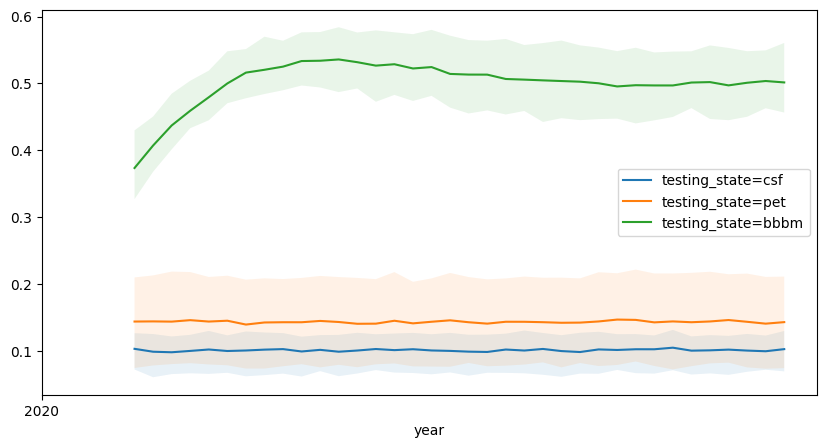

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
plot_over_time_by_column(
    sim_test_rates
    .query("location == 'United States of America' and scenario == 'baseline' and testing_state != 'not_tested'"),
    'testing_state')
ax.set_xticks(ax.get_xticks()[::10])
# ax.tick_params(rotation=90)
plt.show()

# Plot existing test rates in baseline for each country

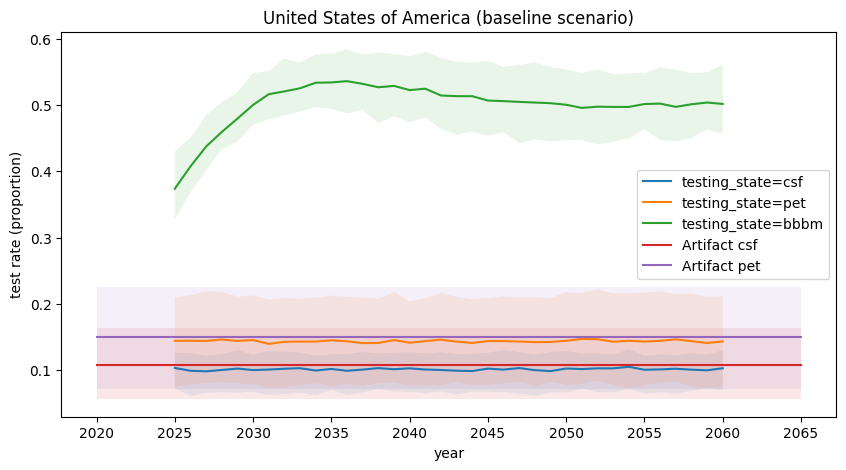

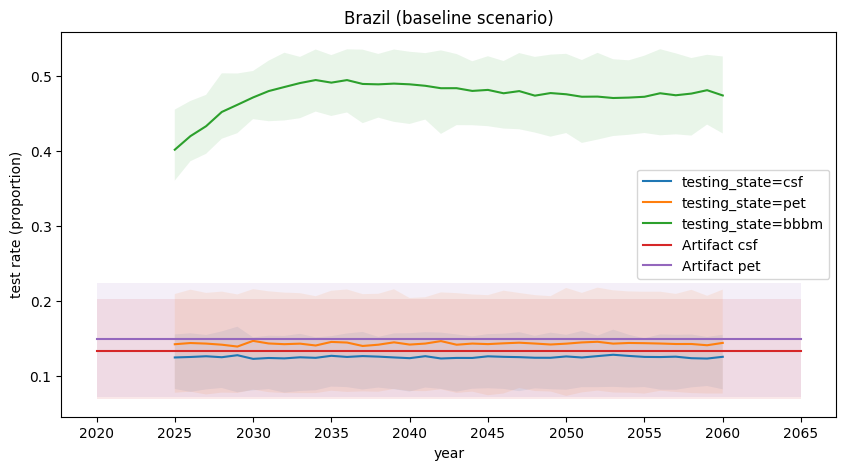

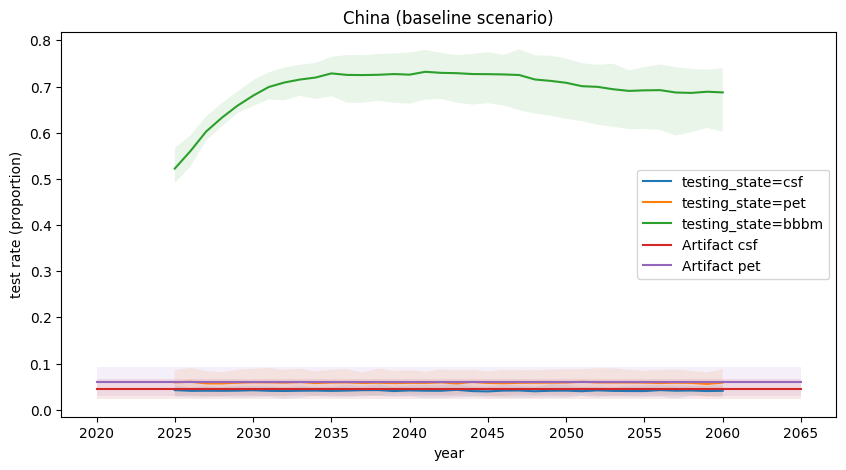

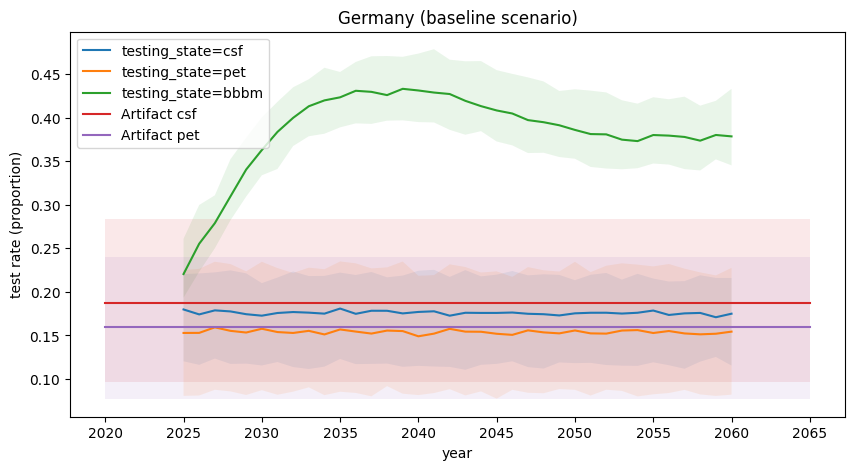

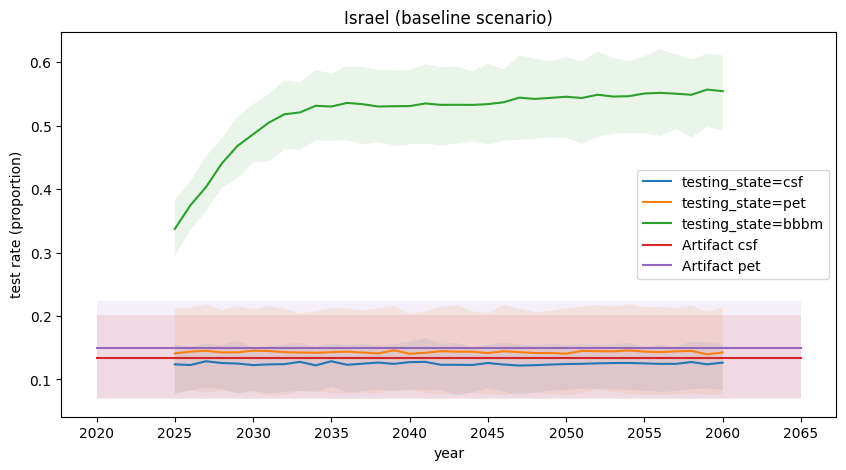

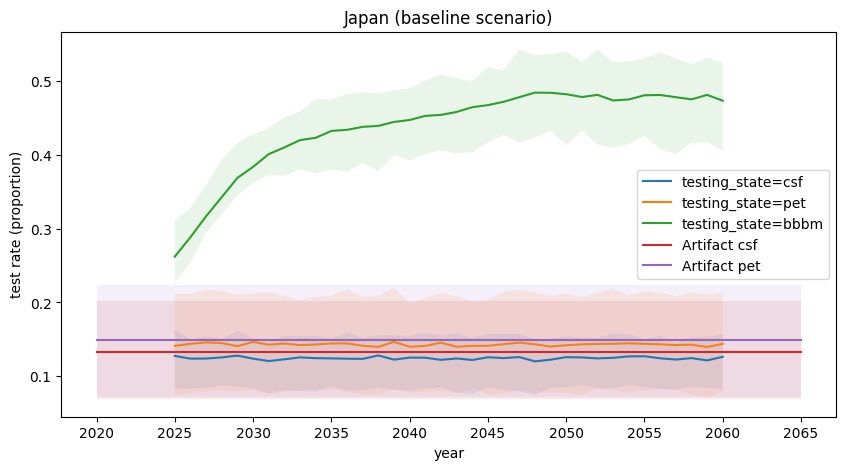

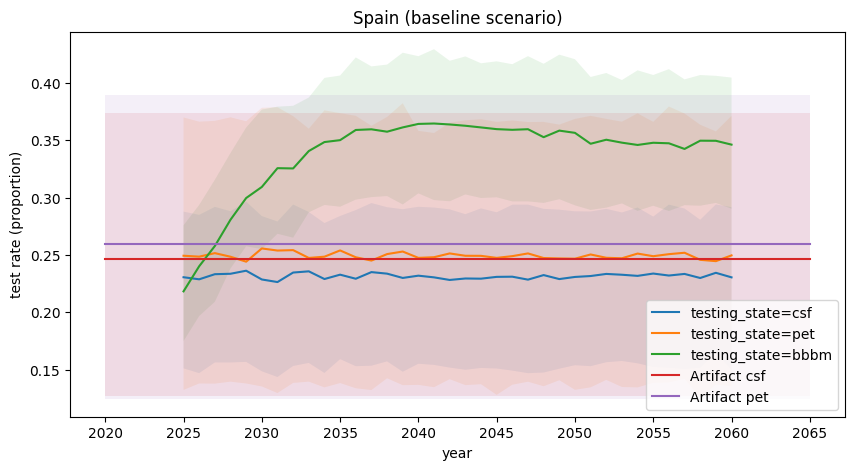

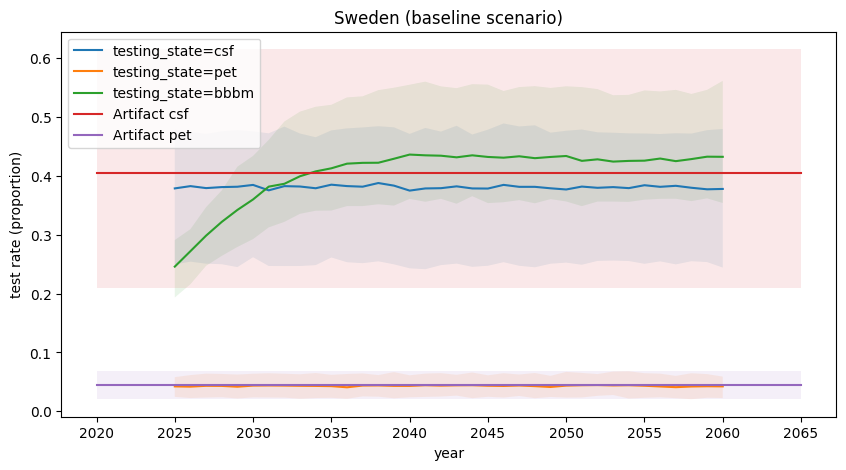

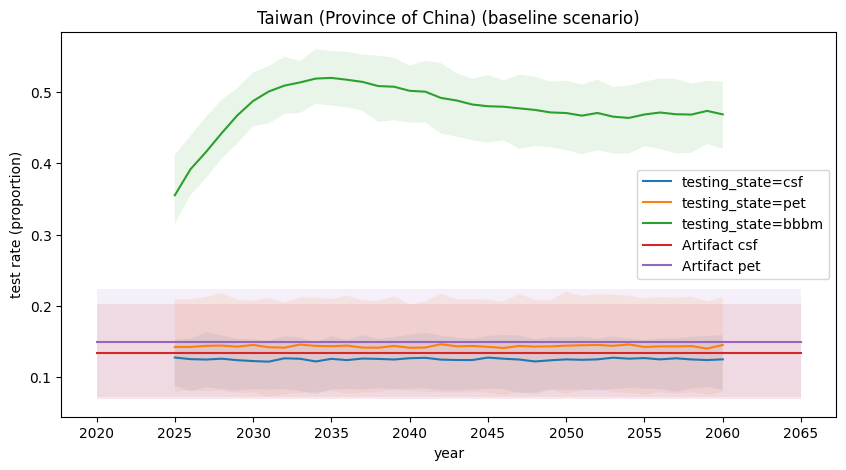

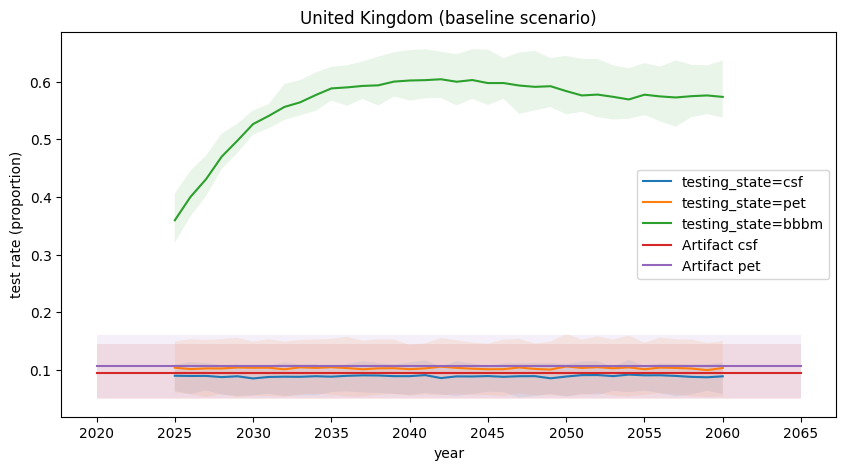

In [31]:
for location in locations:
    fig, ax = plt.subplots(figsize=(10,5))
    plot_over_time_by_column(
        sim_test_rates
        .query("location == @location and scenario == 'baseline' and testing_state != 'not_tested'"),
        'testing_state',
        ylabel='test rate (proportion)',
        title=location + ' (baseline scenario)',
    )
    filtered_x_ticks = ax.get_xticks()#[::5]
    ax.set_xticks(filtered_x_ticks)

    artifact_testing_data = summarize_artifact_data(existing_test_rates).query("location==@location")
    for test_type in artifact_testing_data.index.unique('test_type'):
        ax.plot(
            filtered_x_ticks,
            np.broadcast_to(artifact_testing_data.loc[test_type, 'mean'], (len(filtered_x_ticks),)),
            label=f'Artifact {test_type}'
        )
        ax.fill_between(
            filtered_x_ticks,
            np.broadcast_to(artifact_testing_data.loc[test_type, 'lower'], (len(filtered_x_ticks),)),
            np.broadcast_to(artifact_testing_data.loc[test_type, 'upper'], (len(filtered_x_ticks),)),
            alpha=.1,
        )
    # ax.tick_params(rotation=90)
    # ax.semilogy()
    # ax.set_ylim(0, 0.1)
    ax.legend()
    plt.show()

In [32]:
artifact_testing_data

mean     lower     upper
test_type location                                    
csf       United Kingdom  0.095005  0.049121  0.144264
pet       United Kingdom  0.107058  0.051297  0.160883

# Plot existing tests in baseline and BBBM testing scenarios for one country

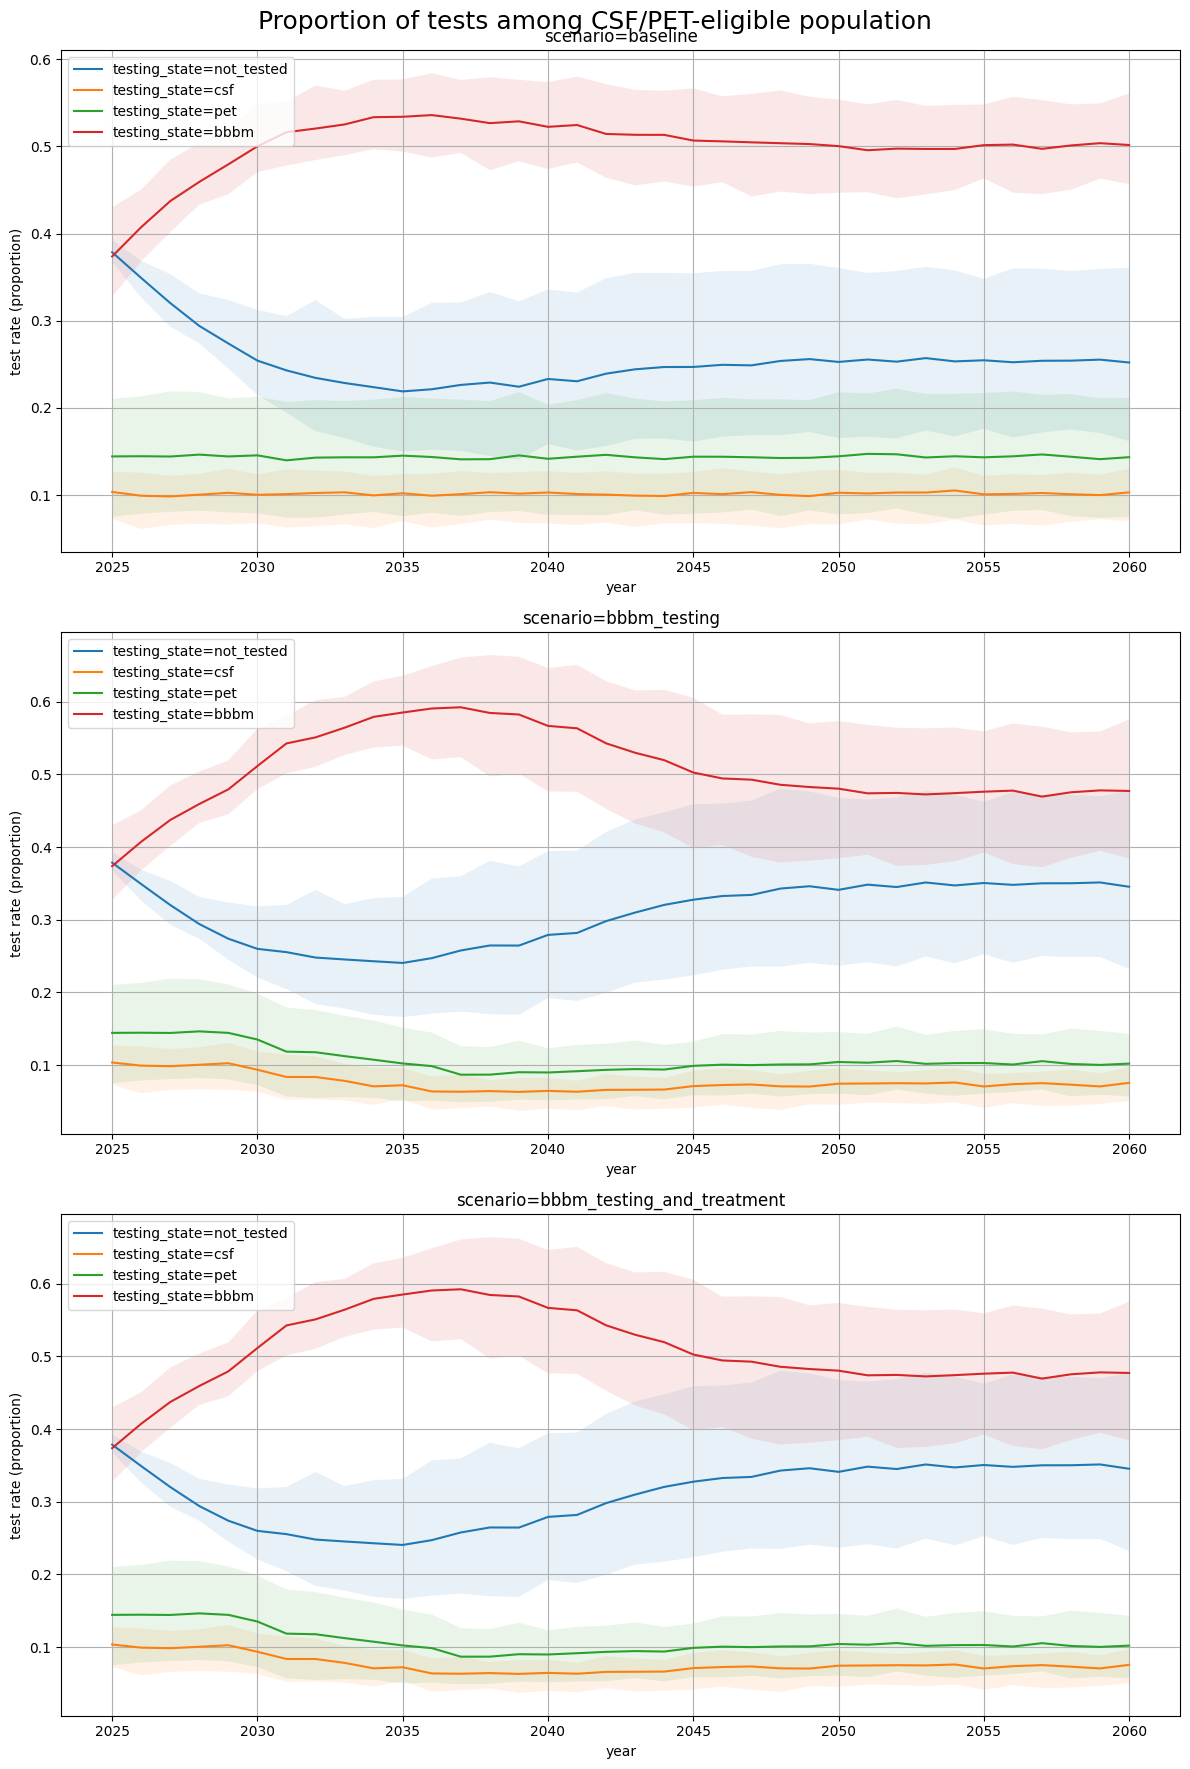

In [33]:
fig = plot_over_time_by_column_for_row_x_1(
    sim_test_rates.query("location == 'United States of America'"),
    'testing_state',
    'scenario',
    ylabel='test rate (proportion)',
    suptitle='Proportion of tests among CSF/PET-eligible population',
)
for ax in fig.axes:
    ax.grid(True)
#     ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Plot existing test rates in BBBM testing scenario for all countries

CSF now decreases at the same time as PET testing. Looks like the bugfix worked.

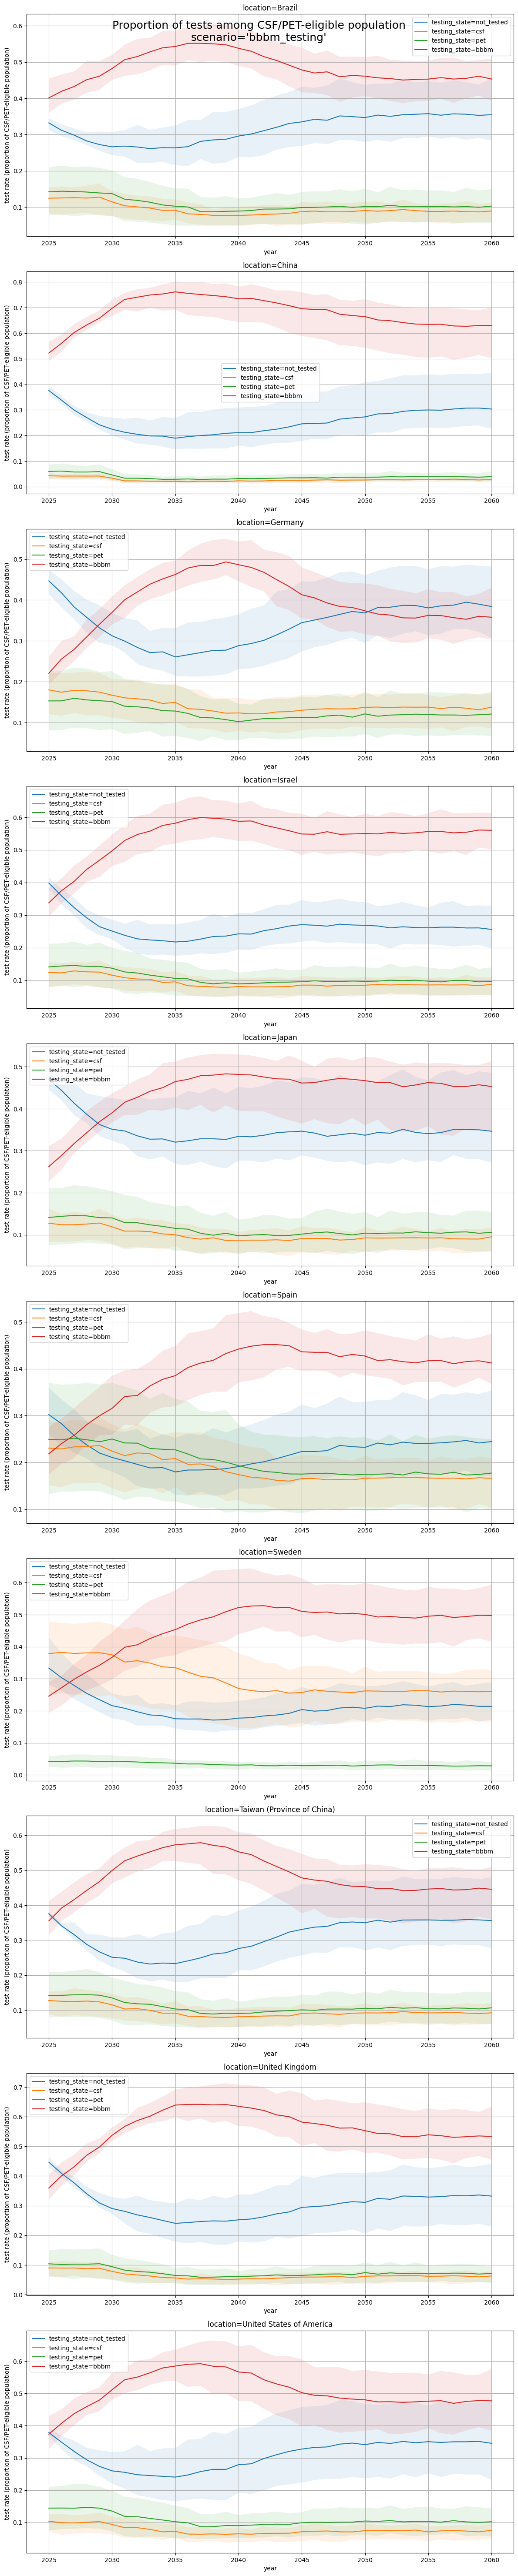

In [34]:
scenario='bbbm_testing'
fig = plot_over_time_by_column_for_row_x_1(
    sim_test_rates.query("scenario == @scenario"),
    'testing_state',
    'location',
    ylabel='test rate (proportion of CSF/PET-eligible population)',
    suptitle=(
        'Proportion of tests among CSF/PET-eligible population'
        f'\n{scenario=}'
    ),
)
for ax in fig.axes:
    ax.grid(True)
#     ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Plot existing test rates in treatment scenario for all countries

These graphs should look the same as the ones in the testing scenario.
And they do. Good.

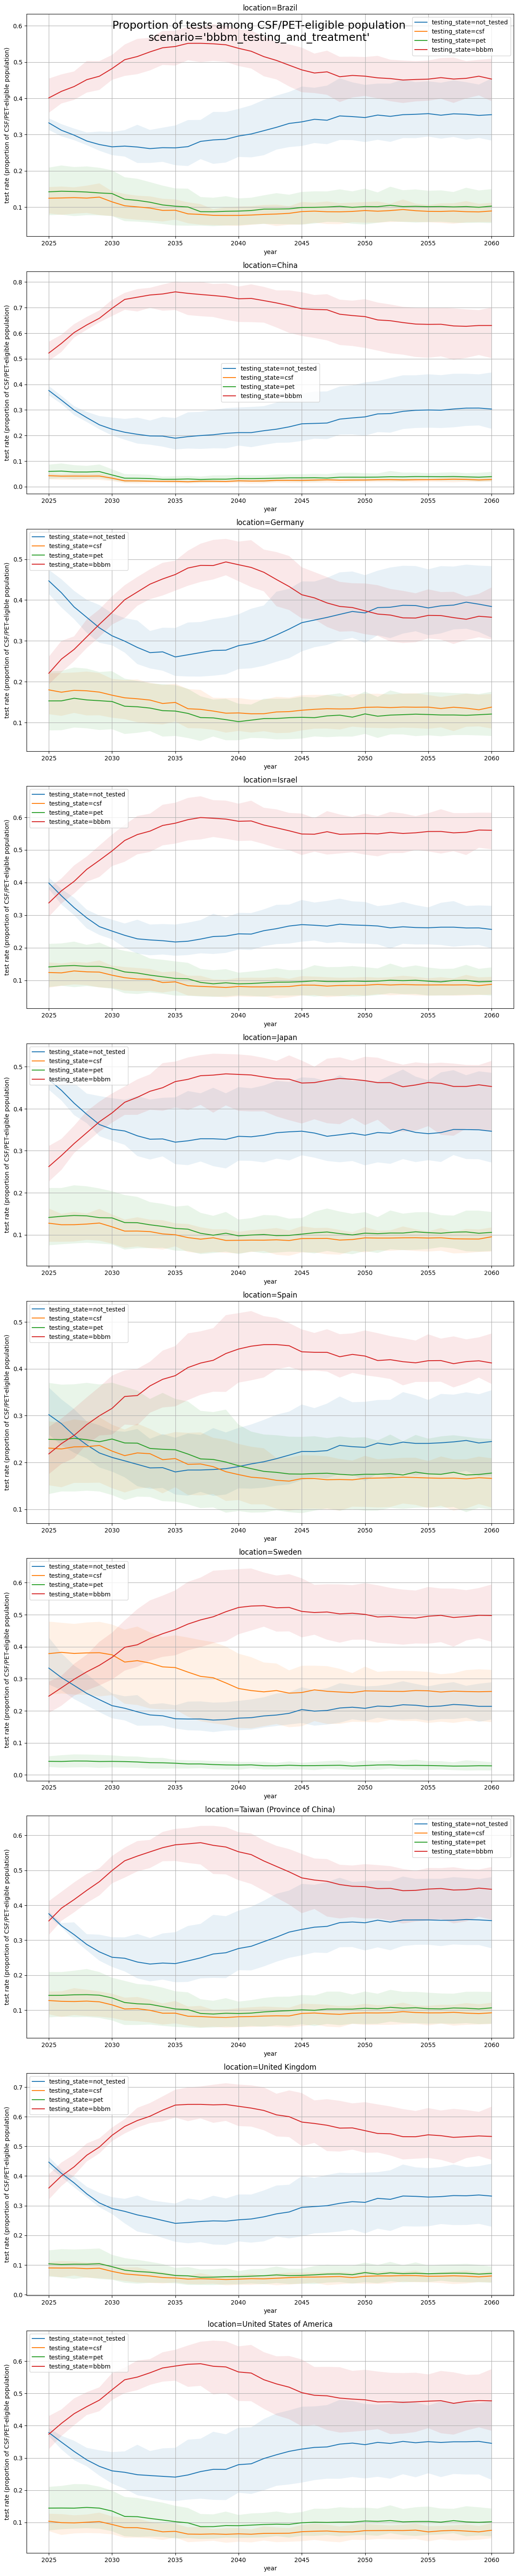

In [35]:
scenario='bbbm_testing_and_treatment'
fig = plot_over_time_by_column_for_row_x_1(
    sim_test_rates.query("scenario == @scenario"),
    'testing_state',
    'location',
    ylabel='test rate (proportion of CSF/PET-eligible population)',
    suptitle=(
        'Proportion of tests among CSF/PET-eligible population'
        f'\n{scenario=}'
    ),
)
for ax in fig.axes:
    ax.grid(True)
#     ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Read BBBM testing data

In [36]:
bbbm_test_eligibility_counts = load_sim_output(
    'counts_newly_eligible_for_bbbm_testing',
)
print_memory_usage(bbbm_test_eligibility_counts)
bbbm_test_eligibility_counts

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/germany.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/israel.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/japan.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/spain.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/taiwan_(province_of_china).hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/a

9.726106 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
485995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
485996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
485997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
485998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
485999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

       bbbm_test_results        entity entity_type  event_year input_draw  \
0             not_tested  bbbm_testing     testing        2025        392   
1             not_tested  bbbm_testing     testing        2025        392   
2             not_tested  bbbm_testing     testing        2025        392   
3             not_tested  bbbm_testing     testing        2025        392   
4             not_tested  bbbm_testing     testing        2025        392   
...                  ...           ...         ...         ...        ...   
485995          negative  bbbm_testing     testing        2060        346   
485996          negative  bbbm_testing     testing        2060        346   
485997          negative  bbbm_testing     testing        2060        346   
485998          negative  bbbm_testing     testing        2060        346   
485999          negative  bbbm_testing     testing        2060        346   

                                       measure                    scenario  \
0       counts_newly_eligible_for_bbbm_testing                    baseline   
1       counts_newly_eligible_for_bbbm_testing                    baseline   
2       counts_newly_eligible_for_bbbm_testing                bbbm_testing   
3       counts_newly_eligible_for_bbbm_testing                bbbm_testing   
4       counts_newly_eligible_for_bbbm_testing  bbbm_testing_and_treatment   
...                                        ...                         ...   
485995  counts_newly_eligible_for_bbbm_testing                    baseline   
485996  counts_newly_eligible_for_bbbm_testing                bbbm_testing   
485997  counts_newly_eligible_for_bbbm_testing                bbbm_testing   
485998  counts_newly_eligible_for_bbbm_testing  bbbm_testing_and_treatment   
485999  counts_newly_eligible_for_bbbm_testing  bbbm_testing_and_treatment   

           sex  value location  
0       Female    0.0    Japan  
1         Male    0.0    Japan  
2       Female    0.0    Japan  
3         Male    0.0    Japan  
4       Female    0.0    Japan  
...        ...    ...      ...  
485995    Male    0.0    China  
485996  Female    0.0    China  
485997    Male    0.0    China  
485998  Female    0.0    China  
485999    Male    0.0    China  

[486000 rows x 12 columns]

In [37]:
bbbm_test_eligibility_counts.bbbm_test_results.unique()

['not_tested', 'positive', 'negative']
Categories (3, object): ['negative', 'not_tested', 'positive']

In [38]:
bbbm_test_counts = load_sim_output(
    'counts_bbbm_tests',
)
bbbm_test_counts

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/germany.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/israel.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/japan.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/spain.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/taiwan_(province_of_china).hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/a

age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
485995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
485996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
485997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
485998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
485999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

       bbbm_test_results        entity entity_type  event_year input_draw  \
0             not_tested  bbbm_testing     testing        2025        392   
1             not_tested  bbbm_testing     testing        2025        392   
2             not_tested  bbbm_testing     testing        2025        392   
3             not_tested  bbbm_testing     testing        2025        392   
4             not_tested  bbbm_testing     testing        2025        392   
...                  ...           ...         ...         ...        ...   
485995          negative  bbbm_testing     testing        2060        346   
485996          negative  bbbm_testing     testing        2060        346   
485997          negative  bbbm_testing     testing        2060        346   
485998          negative  bbbm_testing     testing        2060        346   
485999          negative  bbbm_testing     testing        2060        346   

                  measure                    scenario     sex  value location  
0       counts_bbbm_tests                    baseline  Female    0.0    Japan  
1       counts_bbbm_tests                    baseline    Male    0.0    Japan  
2       counts_bbbm_tests                bbbm_testing  Female    0.0    Japan  
3       counts_bbbm_tests                bbbm_testing    Male    0.0    Japan  
4       counts_bbbm_tests  bbbm_testing_and_treatment  Female    0.0    Japan  
...                   ...                         ...     ...    ...      ...  
485995  counts_bbbm_tests                    baseline    Male    0.0    China  
485996  counts_bbbm_tests                bbbm_testing  Female    0.0    China  
485997  counts_bbbm_tests                bbbm_testing    Male    0.0    China  
485998  counts_bbbm_tests  bbbm_testing_and_treatment  Female    0.0    China  
485999  counts_bbbm_tests  bbbm_testing_and_treatment    Male    0.0    China  

[486000 rows x 12 columns]

# Check that BBBM tests are only occurring between ages 60-80

Yep. Good.

In [39]:
bbbm_test_eligibility_counts.query("value > 0").age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

In [40]:
bbbm_test_counts.query("value > 0").age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

# Divide to get BBBM testing rates for each year in each location

Aggregate over age groups and sexes to get a single number for each
location and year. Stratify by BBBM test results by broadcasting in the
numerator.

In [41]:
bbbm_test_rate = ops.ratio(
    bbbm_test_counts,
    bbbm_test_eligibility_counts,
     # Location is already in index columns, so stratify by year only
    strata=['event_year'],
    numerator_broadcast='bbbm_test_results',
)
bbbm_test_rate

event_year  input_draw                    scenario  \
0            2025         169                    baseline   
1            2025         169                    baseline   
2            2025         169                    baseline   
3            2025         169                    baseline   
4            2025         169                    baseline   
...           ...         ...                         ...   
16195        2060         457  bbbm_testing_and_treatment   
16196        2060         457  bbbm_testing_and_treatment   
16197        2060         457  bbbm_testing_and_treatment   
16198        2060         457  bbbm_testing_and_treatment   
16199        2060         457  bbbm_testing_and_treatment   

                       location bbbm_test_results     value  \
0                        Brazil        not_tested  0.000000   
1                        Brazil          positive  0.000000   
2                        Brazil          negative  0.000000   
3                         China        not_tested  0.000000   
4                         China          positive  0.000000   
...                         ...               ...       ...   
16195            United Kingdom          positive  0.344832   
16196            United Kingdom          negative  0.094246   
16197  United States of America        not_tested  0.000000   
16198  United States of America          positive  0.355908   
16199  United States of America          negative  0.097182   

       numerator_measure                     denominator_measure  multiplier  
0      counts_bbbm_tests  counts_newly_eligible_for_bbbm_testing           1  
1      counts_bbbm_tests  counts_newly_eligible_for_bbbm_testing           1  
2      counts_bbbm_tests  counts_newly_eligible_for_bbbm_testing           1  
3      counts_bbbm_tests  counts_newly_eligible_for_bbbm_testing           1  
4      counts_bbbm_tests  counts_newly_eligible_for_bbbm_testing           1  
...                  ...                                     ...         ...  
16195  counts_bbbm_tests  counts_newly_eligible_for_bbbm_testing           1  
16196  counts_bbbm_tests  counts_newly_eligible_for_bbbm_testing           1  
16197  counts_bbbm_tests  counts_newly_eligible_for_bbbm_testing           1  
16198  counts_bbbm_tests  counts_newly_eligible_for_bbbm_testing           1  
16199  counts_bbbm_tests  counts_newly_eligible_for_bbbm_testing           1  

[16200 rows x 9 columns]

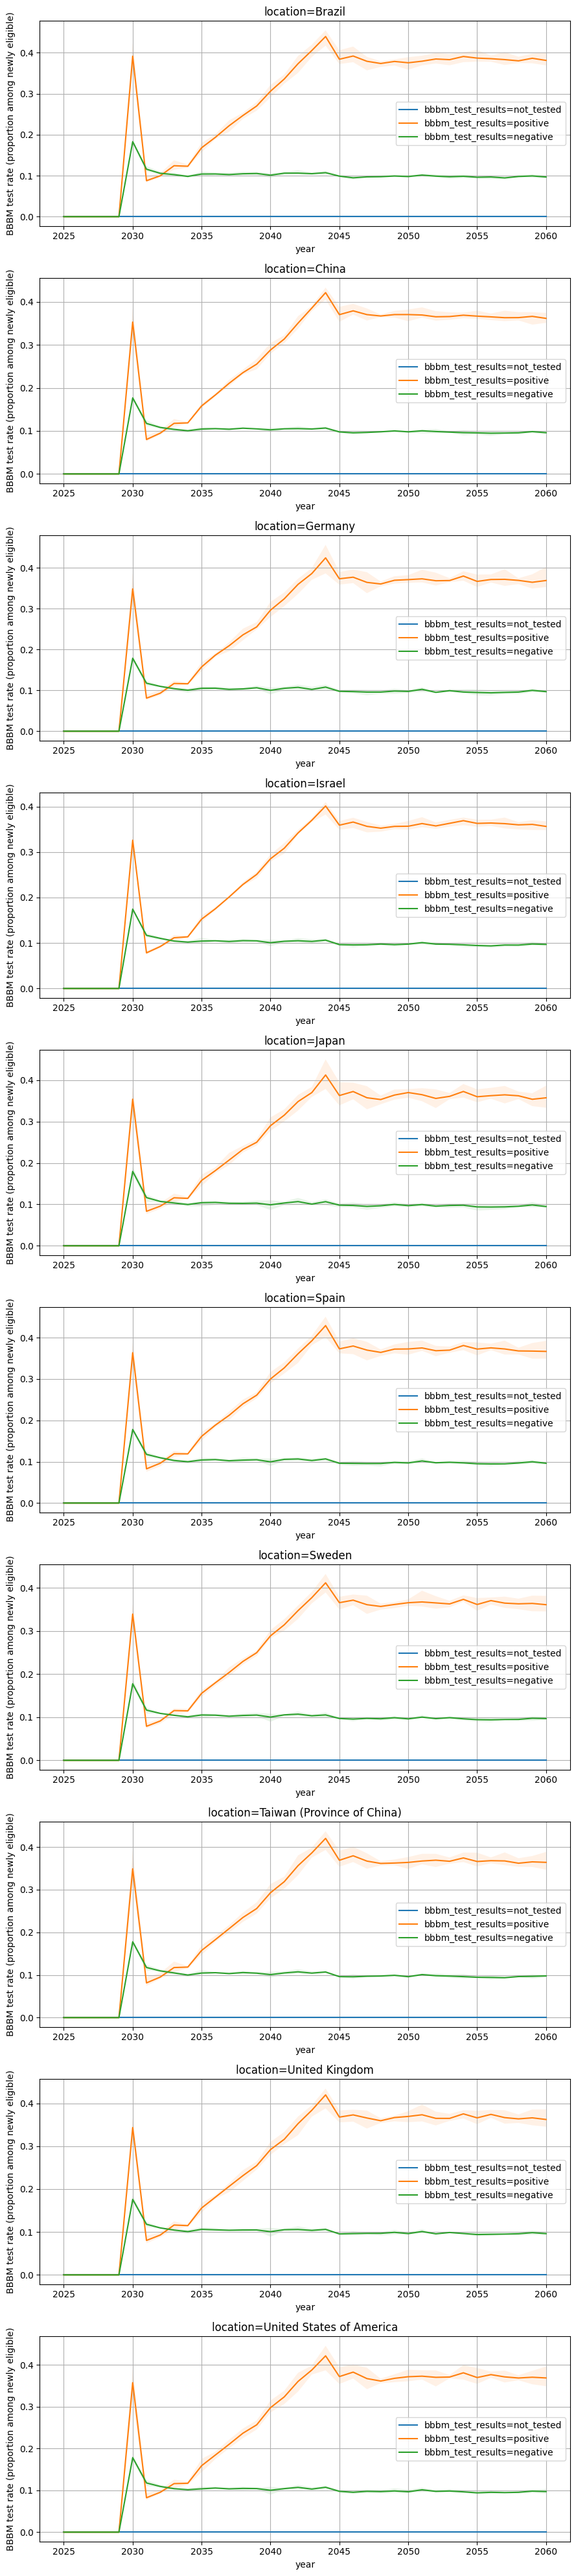

In [42]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_rate.query("scenario=='bbbm_testing'"),
    'bbbm_test_results',
    'location',
    ylabel='BBBM test rate (proportion among newly eligible)',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.grid(True)
#     ax.set_xticks(ax.get_xticks()[::5])
plt.show()


# Check whether `not_tested` is ever nonzero among BBBM test counts

No, it's always zero. That's good.

In [43]:
# Good -- when counting tested simulants, the results are never "not tested"
bbbm_test_counts.query("bbbm_test_results == 'not_tested'").value.unique()

array([0.])

In [44]:
# On the other hand, among eligible simulants, there are lots of people
# who haven't been tested
bbbm_test_eligibility_counts.query("bbbm_test_results == 'not_tested'").value.unique()

array([  0.,  19.,   5.,  21.,  27.,  10.,  13.,  20.,  15.,  31.,   9.,
        25.,  29.,  52.,  32.,  35.,  22.,  39.,  64.,  28.,  26.,  14.,
        34.,  17.,  18.,  23.,  50.,  38.,  16.,  48.,  36.,  33.,  55.,
        40.,  11.,  45.,  43.,  37.,  42.,  12.,  24.,  46.,   7.,  41.,
         8.,   4.,  53.,  30.,  57.,   6.,  54.,  44.,  49.,   3.,   2.,
         1.,  47.,  58.,  51.,  63.,  60.,  56.,  59.,  67.,  62.,  69.,
        70.,  66.,  72.,  77.,  87.,  78., 103.,  98., 100.,  84.,  85.,
       109.,  83.,  91., 106.,  74., 119.,  92.,  90.,  73.,  79.,  71.,
        65.,  76.,  68.,  61.,  96.,  89.,  81.,  86.,  97., 113.,  93.,
       115.,  80., 110.,  99.,  75.,  82.,  88., 101., 108., 112.,  94.,
       111., 150., 125., 137., 126., 104., 121., 144., 114., 124., 120.,
       122., 146., 117., 107., 129., 105., 138., 102., 131., 116., 132.,
        95., 141., 118., 199., 271., 247., 170., 220., 187., 245., 243.,
       179., 227., 194., 226., 235., 164., 210., 16

# Check that among eligible similants, there are no positive tests

Yes, all counts of positive tests among eligible simulants are zero.

In [45]:
# Good -- among eligible simulants, no one has tested positive.
bbbm_test_eligibility_counts.query("bbbm_test_results == 'positive'").value.unique()

array([0.])

In [46]:
# On the other hand, among tested simulants, there are positive test results
len(bbbm_test_counts.query("bbbm_test_results == 'positive'").value.unique())

1218

# Check test sensitivity

Filter to testing scenario and/or treatment scenario since there are no BBBM tests in baseline.

In [47]:
bbbm_test_sensitivity = ops.ratio(
    bbbm_test_counts,
    bbbm_test_counts,
    strata=['event_year'],
    # prefilter_query="scenario=='bbbm_testing'",
    # Broadcast in numerator to get positive and negative test results
    numerator_broadcast='bbbm_test_results',
    # dropna=True, # Drop rows with 0 testing (baseline scenario and years < 2030)
)
bbbm_test_sensitivity

event_year  input_draw                    scenario  \
0            2025         169                    baseline   
1            2025         169                    baseline   
2            2025         169                    baseline   
3            2025         169                    baseline   
4            2025         169                    baseline   
...           ...         ...                         ...   
16195        2060         457  bbbm_testing_and_treatment   
16196        2060         457  bbbm_testing_and_treatment   
16197        2060         457  bbbm_testing_and_treatment   
16198        2060         457  bbbm_testing_and_treatment   
16199        2060         457  bbbm_testing_and_treatment   

                       location bbbm_test_results     value  \
0                        Brazil        not_tested       NaN   
1                        Brazil          positive       NaN   
2                        Brazil          negative       NaN   
3                         China        not_tested       NaN   
4                         China          positive       NaN   
...                         ...               ...       ...   
16195            United Kingdom          positive  0.785355   
16196            United Kingdom          negative  0.214645   
16197  United States of America        not_tested  0.000000   
16198  United States of America          positive  0.785512   
16199  United States of America          negative  0.214488   

       numerator_measure denominator_measure  multiplier  
0      counts_bbbm_tests   counts_bbbm_tests           1  
1      counts_bbbm_tests   counts_bbbm_tests           1  
2      counts_bbbm_tests   counts_bbbm_tests           1  
3      counts_bbbm_tests   counts_bbbm_tests           1  
4      counts_bbbm_tests   counts_bbbm_tests           1  
...                  ...                 ...         ...  
16195  counts_bbbm_tests   counts_bbbm_tests           1  
16196  counts_bbbm_tests   counts_bbbm_tests           1  
16197  counts_bbbm_tests   counts_bbbm_tests           1  
16198  counts_bbbm_tests   counts_bbbm_tests           1  
16199  counts_bbbm_tests   counts_bbbm_tests           1  

[16200 rows x 9 columns]

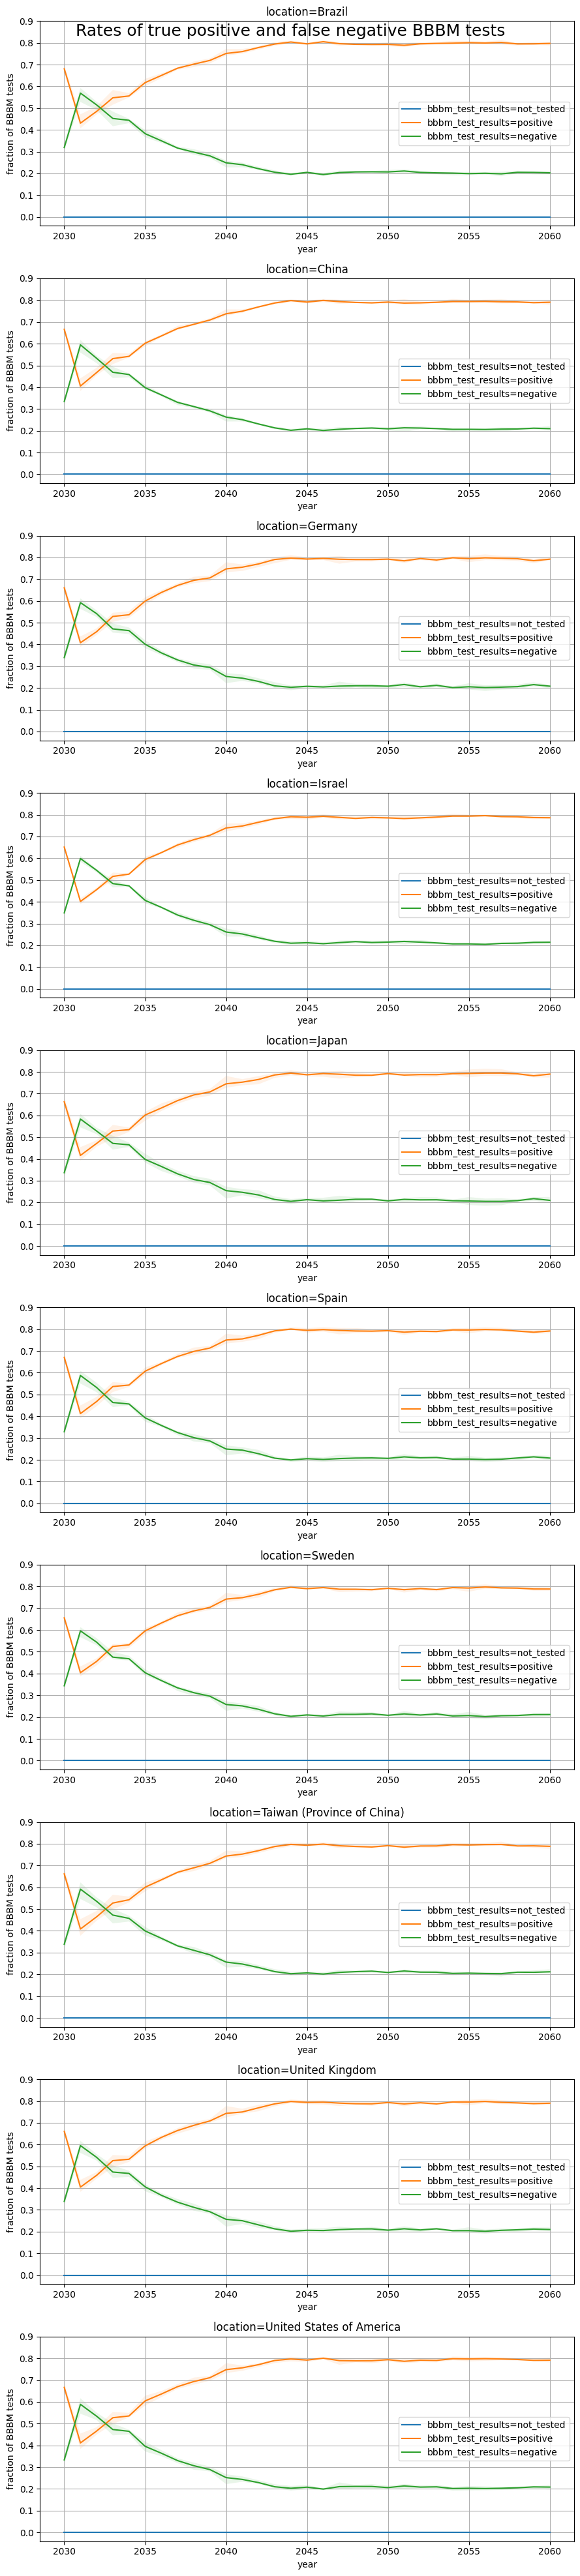

In [48]:
scenario = 'bbbm_testing_and_treatment'
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_sensitivity.query("scenario == 'bbbm_testing_and_treatment'"),
    'bbbm_test_results',
    'location',
    ylabel='fraction of BBBM tests',
    suptitle='Rates of true positive and false negative BBBM tests',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::5])
    ax.set_yticks(np.arange(0,1, .1))
    ax.grid(True)
plt.show()


# Compute statistics on BBBM test sensitivity

In [49]:
bbbm_test_sensitivity_summary = ops.describe(
    bbbm_test_sensitivity.dropna().query("event_year >= 2030 and bbbm_test_results=='positive'"))
bbbm_test_sensitivity_summary

count  \
bbbm_test_results denominator_measure event_year location                   multiplier numerator_measure scenario                            
positive          counts_bbbm_tests   2030       Brazil                     1          counts_bbbm_tests bbbm_testing                  5.0   
                                                                                                         bbbm_testing_and_treatment    5.0   
                                                 China                      1          counts_bbbm_tests bbbm_testing                  5.0   
                                                                                                         bbbm_testing_and_treatment    5.0   
                                                 Germany                    1          counts_bbbm_tests bbbm_testing                  5.0   
...                                                                                                                                    ...   
                                      2060       Taiwan (Province of China) 1          counts_bbbm_tests bbbm_testing_and_treatment    5.0   
                                                 United Kingdom             1          counts_bbbm_tests bbbm_testing                  5.0   
                                                                                                         bbbm_testing_and_treatment    5.0   
                                                 United States of America   1          counts_bbbm_tests bbbm_testing                  5.0   
                                                                                                         bbbm_testing_and_treatment    5.0   

                                                                                                                                         mean  \
bbbm_test_results denominator_measure event_year location                   multiplier numerator_measure scenario                               
positive          counts_bbbm_tests   2030       Brazil                     1          counts_bbbm_tests bbbm_testing                0.680909   
                                                                                                         bbbm_testing_and_treatment  0.680909   
                                                 China                      1          counts_bbbm_tests bbbm_testing                0.665831   
                                                                                                         bbbm_testing_and_treatment  0.665831   
                                                 Germany                    1          counts_bbbm_tests bbbm_testing                0.660211   
...                                                                                                                                       ...   
                                      2060       Taiwan (Province of China) 1          counts_bbbm_tests bbbm_testing_and_treatment  0.788157   
                                                 United Kingdom             1          counts_bbbm_tests bbbm_testing                0.790041   
                                                                                                         bbbm_testing_and_treatment  0.790041   
                                                 United States of America   1          counts_bbbm_tests bbbm_testing                0.791423   
                                                                                                         bbbm_testing_and_treatment  0.791423   

                                                                                                                                          std  \
bbbm_test_results denominator_measure event_year location                   multiplier numerator_measure scenario                               
positive          counts_bbbm_tests   2030       Brazil                     1          counts_bbbm_tests bbbm_

In [50]:
bbbm_test_sensitivity_summary['mean'].describe()

count    620.000000
mean       0.723736
std        0.107136
min        0.401516
25%        0.674708
50%        0.786755
75%        0.792556
max        0.805154
Name: mean, dtype: float64

# Compute test result fractions among newly eligible simulants

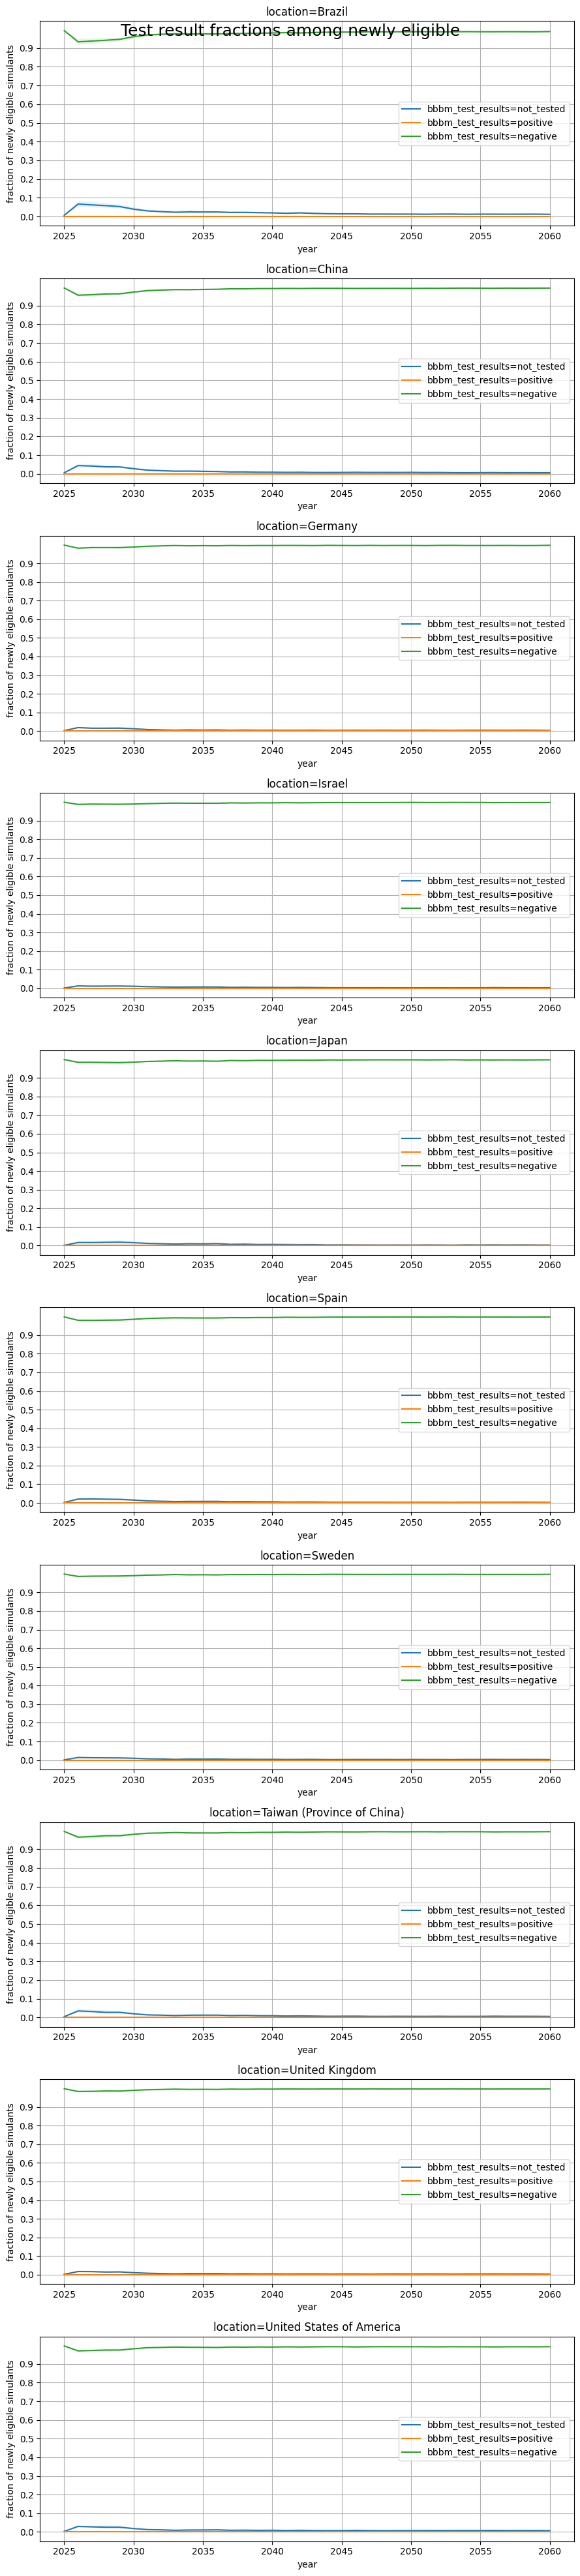

In [51]:
# TODO: Here would be a great place to use prefilter_query in the ratio
# function, once I implement it
bbbm_test_result_fractions_among_eligible = ops.ratio(
    bbbm_test_eligibility_counts.query("scenario=='bbbm_testing'"),
    bbbm_test_eligibility_counts.query("scenario=='bbbm_testing'"),
    strata=['event_year'],
    numerator_broadcast='bbbm_test_results',
)

fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_result_fractions_among_eligible,
    'bbbm_test_results',
    'location',
    ylabel='fraction of newly eligible simulants',
    suptitle='Test result fractions among newly eligible',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.set_xticks(ax.get_xticks()[::5])
    ax.set_yticks(np.arange(0,1, .1))
plt.show()

# Plot numerators and denominators of BBBM test rate

In [52]:
bbbm_test_rate_numerator = ops.stratify(bbbm_test_counts, 'event_year')
bbbm_test_rate_denominator = ops.stratify(bbbm_test_eligibility_counts, 'event_year')
bbbm_test_rate_num_and_denom = pd.concat(
    [bbbm_test_rate_numerator, bbbm_test_rate_denominator],
    keys=['tests', 'newly_eligible'],
    names=['count'],
).reset_index('count').reset_index(drop=True)
bbbm_test_rate_num_and_denom

count  event_year input_draw                    scenario  \
0               tests        2025        392                    baseline   
1               tests        2025        392                    baseline   
2               tests        2025        392                    baseline   
3               tests        2025        392                    baseline   
4               tests        2025        392                    baseline   
...               ...         ...        ...                         ...   
10795  newly_eligible        2060        346  bbbm_testing_and_treatment   
10796  newly_eligible        2060        346  bbbm_testing_and_treatment   
10797  newly_eligible        2060        346  bbbm_testing_and_treatment   
10798  newly_eligible        2060        346  bbbm_testing_and_treatment   
10799  newly_eligible        2060        346  bbbm_testing_and_treatment   

                         location   value  
0                          Brazil     0.0  
1                           China     0.0  
2                         Germany     0.0  
3                          Israel     0.0  
4                           Japan     0.0  
...                           ...     ...  
10795                       Spain  5160.0  
10796                      Sweden  4855.0  
10797  Taiwan (Province of China)  5732.0  
10798              United Kingdom  5332.0  
10799    United States of America  4556.0  

[10800 rows x 6 columns]

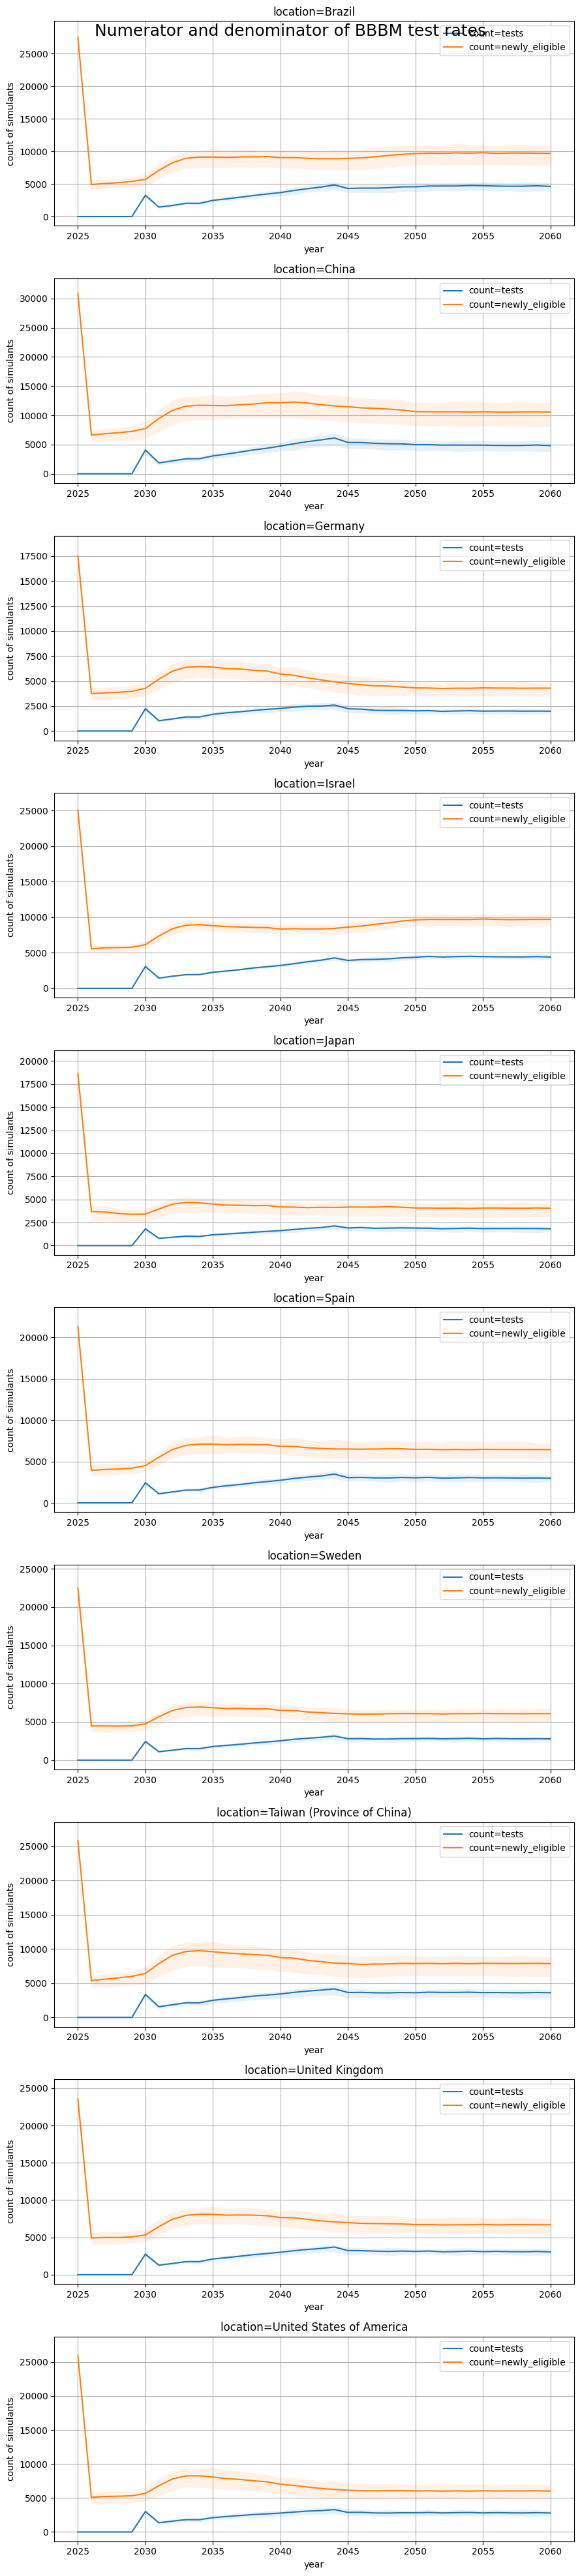

In [53]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_rate_num_and_denom.query("scenario=='bbbm_testing'"),
    'count',
    'location',
    ylabel='count of simulants',
    suptitle='Numerator and denominator of BBBM test rates',
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Read in BBBM testing person-time data

In [54]:
pt_ever_eligible_bbbm = load_sim_output(
    'person_time_ever_eligible_for_bbbm_testing'
)
print_memory_usage(pt_ever_eligible_bbbm)
pt_ever_eligible_bbbm

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/germany.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/israel.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/japan.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/spain.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/taiwan_(province_of_china).hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/a

30.624493 MB


age_group  alzheimers_disease_and_other_dementias  \
0        25_to_29  alzheimers_blood_based_biomarker_state   
1        25_to_29  alzheimers_blood_based_biomarker_state   
2        25_to_29  alzheimers_blood_based_biomarker_state   
3        25_to_29  alzheimers_blood_based_biomarker_state   
4        25_to_29  alzheimers_blood_based_biomarker_state   
...           ...                                     ...   
1457995   95_plus                alzheimers_disease_state   
1457996   95_plus                alzheimers_disease_state   
1457997   95_plus                alzheimers_disease_state   
1457998   95_plus                alzheimers_disease_state   
1457999   95_plus                alzheimers_disease_state   

                                             artifact_path bbbm_test_results  \
0        /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1        /mnt/team/simulation_science/pub/models/vivari...        not_tested   
2        /mnt/team/simulation_science/pub/models/vivari...        not_tested   
3        /mnt/team/simulation_science/pub/models/vivari...        not_tested   
4        /mnt/team/simulation_science/pub/models/vivari...        not_tested   
...                                                    ...               ...   
1457995  /mnt/team/simulation_science/pub/models/vivari...          negative   
1457996  /mnt/team/simulation_science/pub/models/vivari...          negative   
1457997  /mnt/team/simulation_science/pub/models/vivari...          negative   
1457998  /mnt/team/simulation_science/pub/models/vivari...          negative   
1457999  /mnt/team/simulation_science/pub/models/vivari...          negative   

               entity entity_type  event_year input_draw  \
0        bbbm_testing     testing        2025        392   
1        bbbm_testing     testing        2025        392   
2        bbbm_testing     testing        2025        392   
3        bbbm_testing     testing        2025        392   
4        bbbm_testing     testing        2025        392   
...               ...         ...         ...        ...   
1457995  bbbm_testing     testing        2060        346   
1457996  bbbm_testing     testing        2060        346   
1457997  bbbm_testing     testing        2060        346   
1457998  bbbm_testing     testing        2060        346   
1457999  bbbm_testing     testing        2060        346   

                                            measure  \
0        person_time_ever_eligible_for_bbbm_testing   
1        person_time_ever_eligible_for_bbbm_testing   
2        person_time_ever_eligible_for_bbbm_testing   
3        person_time_ever_eligible_for_bbbm_testing   
4        person_time_ever_eligible_for_bbbm_testing   
...                                             ...   
1457995  person_time_ever_eligible_for_bbbm_testing   
1457996  person_time_ever_eligible_for_bbbm_testing   
1457997  person_time_ever_eligible_for_bbbm_testing   
1457998  person_time_ever_eligible_for_bbbm_testing   
1457999  person_time_ever_eligible_for_bbbm_testing   

                           scenario     sex       value location  
0                          baseline  Female    0.000000    Japan  
1                          baseline    Male    0.000000    Japan  
2                      bbbm_testing  Female    0.000000    Japan  
3                      bbbm_testing    Male    0.000000    Japan  
4        bbbm_testing_and_treatment  Female    0.000000    Japan  
...                             ...     ...         ...      ...  
1457995                    baseline    Male   69.262149    China  
1457996                bbbm_testing  Female  312.925394    China  
1457997                bbbm_testing    Male   49.330595    China  
1457998  bbbm_testing_and_treatment  Female  312.925394    China  
1457999  bbbm_testing_and_treatment    Male   49.330595    China  

[1458000 rows x 13 columns]

In [55]:
pt_eligible_bbbm = load_sim_output(
    'person_time_eligible_for_bbbm_testing'
)
print_memory_usage(pt_eligible_bbbm)
pt_eligible_bbbm

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/germany.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/israel.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/japan.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/spain.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/taiwan_(province_of_china).hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/a

9.726105 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
485995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
485996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
485997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
485998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
485999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

       bbbm_test_results        entity entity_type  event_year input_draw  \
0             not_tested  bbbm_testing     testing        2025        392   
1             not_tested  bbbm_testing     testing        2025        392   
2             not_tested  bbbm_testing     testing        2025        392   
3             not_tested  bbbm_testing     testing        2025        392   
4             not_tested  bbbm_testing     testing        2025        392   
...                  ...           ...         ...         ...        ...   
485995          negative  bbbm_testing     testing        2060        346   
485996          negative  bbbm_testing     testing        2060        346   
485997          negative  bbbm_testing     testing        2060        346   
485998          negative  bbbm_testing     testing        2060        346   
485999          negative  bbbm_testing     testing        2060        346   

                                      measure                    scenario  \
0       person_time_eligible_for_bbbm_testing                    baseline   
1       person_time_eligible_for_bbbm_testing                    baseline   
2       person_time_eligible_for_bbbm_testing                bbbm_testing   
3       person_time_eligible_for_bbbm_testing                bbbm_testing   
4       person_time_eligible_for_bbbm_testing  bbbm_testing_and_treatment   
...                                       ...                         ...   
485995  person_time_eligible_for_bbbm_testing                    baseline   
485996  person_time_eligible_for_bbbm_testing                bbbm_testing   
485997  person_time_eligible_for_bbbm_testing                bbbm_testing   
485998  person_time_eligible_for_bbbm_testing  bbbm_testing_and_treatment   
485999  person_time_eligible_for_bbbm_testing  bbbm_testing_and_treatment   

           sex  value location  
0       Female    0.0    Japan  
1         Male    0.0    Japan  
2       Female    0.0    Japan  
3         Male    0.0    Japan  
4       Female    0.0    Japan  
...        ...    ...      ...  
485995    Male    0.0    China  
485996  Female    0.0    China  
485997    Male    0.0    China  
485998  Female    0.0    China  
485999    Male    0.0    China  

[486000 rows x 12 columns]

# Plot BBBM testing rate (counts / eligible person-time)

In [56]:
bbbm_tests_per_eligible_pt = ops.ratio(
    bbbm_test_counts,
    pt_eligible_bbbm,
    strata='event_year',
    # numerator_broadcast='bbbm_test_results',
)
bbbm_tests_per_eligible_pt

event_year input_draw                    scenario  \
0           2025        392                    baseline   
1           2025        392                    baseline   
2           2025        392                    baseline   
3           2025        392                    baseline   
4           2025        392                    baseline   
...          ...        ...                         ...   
5395        2060        346  bbbm_testing_and_treatment   
5396        2060        346  bbbm_testing_and_treatment   
5397        2060        346  bbbm_testing_and_treatment   
5398        2060        346  bbbm_testing_and_treatment   
5399        2060        346  bbbm_testing_and_treatment   

                        location     value  numerator_measure  \
0                         Brazil  0.000000  counts_bbbm_tests   
1                          China  0.000000  counts_bbbm_tests   
2                        Germany  0.000000  counts_bbbm_tests   
3                         Israel  0.000000  counts_bbbm_tests   
4                          Japan  0.000000  counts_bbbm_tests   
...                          ...       ...                ...   
5395                       Spain  0.560102  counts_bbbm_tests   
5396                      Sweden  0.592046  counts_bbbm_tests   
5397  Taiwan (Province of China)  0.556485  counts_bbbm_tests   
5398              United Kingdom  0.582625  counts_bbbm_tests   
5399    United States of America  0.554338  counts_bbbm_tests   

                        denominator_measure  multiplier  
0     person_time_eligible_for_bbbm_testing           1  
1     person_time_eligible_for_bbbm_testing           1  
2     person_time_eligible_for_bbbm_testing           1  
3     person_time_eligible_for_bbbm_testing           1  
4     person_time_eligible_for_bbbm_testing           1  
...                                     ...         ...  
5395  person_time_eligible_for_bbbm_testing           1  
5396  person_time_eligible_for_bbbm_testing           1  
5397  person_time_eligible_for_bbbm_testing           1  
5398  person_time_eligible_for_bbbm_testing           1  
5399  person_time_eligible_for_bbbm_testing           1  

[5400 rows x 8 columns]

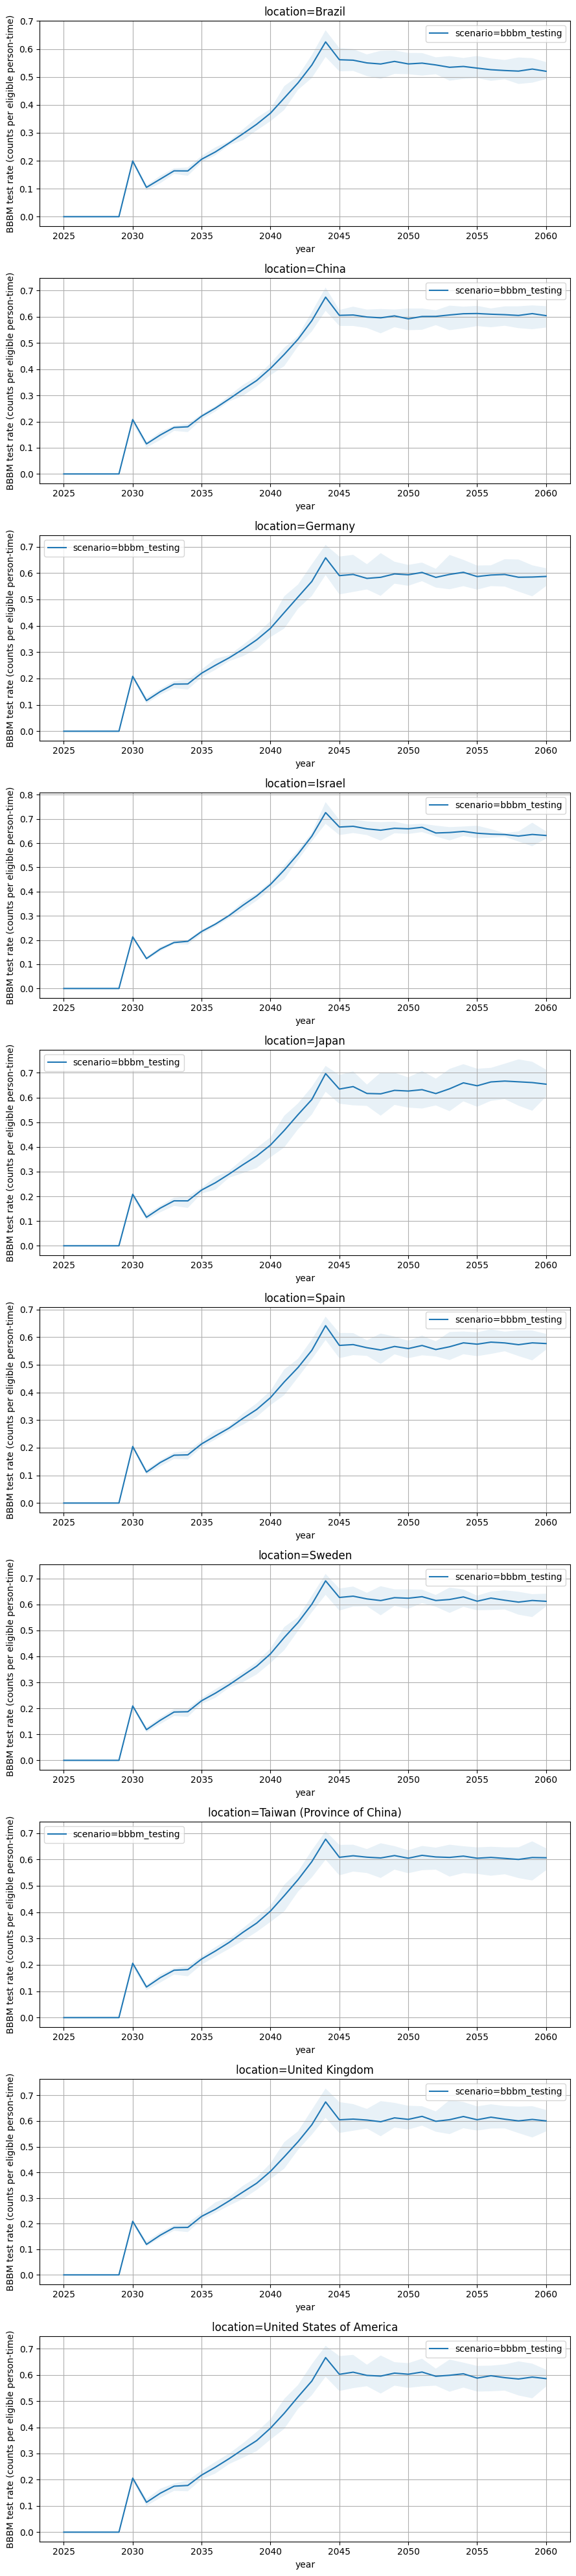

In [57]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_tests_per_eligible_pt.query("scenario=='bbbm_testing'"),
    # 'bbbm_test_results',
    'scenario',
    'location',
    ylabel='BBBM test rate (counts per eligible person-time)',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::5])
    ax.grid(True)
plt.show()


# Compute prevalence of ever tested among ever eligible

In [58]:
pt_ever_eligible_bbbm.bbbm_test_results.unique()

['not_tested', 'positive', 'negative']
Categories (3, object): ['negative', 'not_tested', 'positive']

In [59]:
pt_ever_eligible_bbbm

age_group  alzheimers_disease_and_other_dementias  \
0        25_to_29  alzheimers_blood_based_biomarker_state   
1        25_to_29  alzheimers_blood_based_biomarker_state   
2        25_to_29  alzheimers_blood_based_biomarker_state   
3        25_to_29  alzheimers_blood_based_biomarker_state   
4        25_to_29  alzheimers_blood_based_biomarker_state   
...           ...                                     ...   
1457995   95_plus                alzheimers_disease_state   
1457996   95_plus                alzheimers_disease_state   
1457997   95_plus                alzheimers_disease_state   
1457998   95_plus                alzheimers_disease_state   
1457999   95_plus                alzheimers_disease_state   

                                             artifact_path bbbm_test_results  \
0        /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1        /mnt/team/simulation_science/pub/models/vivari...        not_tested   
2        /mnt/team/simulation_science/pub/models/vivari...        not_tested   
3        /mnt/team/simulation_science/pub/models/vivari...        not_tested   
4        /mnt/team/simulation_science/pub/models/vivari...        not_tested   
...                                                    ...               ...   
1457995  /mnt/team/simulation_science/pub/models/vivari...          negative   
1457996  /mnt/team/simulation_science/pub/models/vivari...          negative   
1457997  /mnt/team/simulation_science/pub/models/vivari...          negative   
1457998  /mnt/team/simulation_science/pub/models/vivari...          negative   
1457999  /mnt/team/simulation_science/pub/models/vivari...          negative   

               entity entity_type  event_year input_draw  \
0        bbbm_testing     testing        2025        392   
1        bbbm_testing     testing        2025        392   
2        bbbm_testing     testing        2025        392   
3        bbbm_testing     testing        2025        392   
4        bbbm_testing     testing        2025        392   
...               ...         ...         ...        ...   
1457995  bbbm_testing     testing        2060        346   
1457996  bbbm_testing     testing        2060        346   
1457997  bbbm_testing     testing        2060        346   
1457998  bbbm_testing     testing        2060        346   
1457999  bbbm_testing     testing        2060        346   

                                            measure  \
0        person_time_ever_eligible_for_bbbm_testing   
1        person_time_ever_eligible_for_bbbm_testing   
2        person_time_ever_eligible_for_bbbm_testing   
3        person_time_ever_eligible_for_bbbm_testing   
4        person_time_ever_eligible_for_bbbm_testing   
...                                             ...   
1457995  person_time_ever_eligible_for_bbbm_testing   
1457996  person_time_ever_eligible_for_bbbm_testing   
1457997  person_time_ever_eligible_for_bbbm_testing   
1457998  person_time_ever_eligible_for_bbbm_testing   
1457999  person_time_ever_eligible_for_bbbm_testing   

                           scenario     sex       value location  
0                          baseline  Female    0.000000    Japan  
1                          baseline    Male    0.000000    Japan  
2                      bbbm_testing  Female    0.000000    Japan  
3                      bbbm_testing    Male    0.000000    Japan  
4        bbbm_testing_and_treatment  Female    0.000000    Japan  
...                             ...     ...         ...      ...  
1457995                    baseline    Male   69.262149    China  
1457996                bbbm_testing  Female  312.925394    China  
1457997                bbbm_testing    Male   49.330595    China  
1457998  bbbm_testing_and_treatment  Female  312.925394    China  
1457999  bbbm_testing_and_treatment    Male   49.330595    China  

[1458000 rows x 13 columns]

In [60]:
ever_tested_over_ever_eligible = ops.ratio(
    pt_ever_eligible_bbbm.query(
        "bbbm_test_results != 'not_tested'"),
    pt_ever_eligible_bbbm,
    strata=['event_year', 'age_group'],
    prefilter_query="alzheimers_disease_and_other_dementias == 'alzheimers_blood_based_biomarker_state'",
)#.query("scenario == 'bbbm_testing_and_treatment'")
ever_tested_over_ever_eligible

event_year age_group input_draw                    scenario  \
0            2025  25_to_29        392                    baseline   
1            2025  25_to_29        392                    baseline   
2            2025  25_to_29        392                    baseline   
3            2025  25_to_29        392                    baseline   
4            2025  25_to_29        392                    baseline   
...           ...       ...        ...                         ...   
80995        2060   95_plus        346  bbbm_testing_and_treatment   
80996        2060   95_plus        346  bbbm_testing_and_treatment   
80997        2060   95_plus        346  bbbm_testing_and_treatment   
80998        2060   95_plus        346  bbbm_testing_and_treatment   
80999        2060   95_plus        346  bbbm_testing_and_treatment   

                         location  value  \
0                          Brazil    NaN   
1                           China    NaN   
2                         Germany    NaN   
3                          Israel    NaN   
4                           Japan    NaN   
...                           ...    ...   
80995                       Spain    1.0   
80996                      Sweden    1.0   
80997  Taiwan (Province of China)    1.0   
80998              United Kingdom    1.0   
80999    United States of America    1.0   

                                numerator_measure  \
0      person_time_ever_eligible_for_bbbm_testing   
1      person_time_ever_eligible_for_bbbm_testing   
2      person_time_ever_eligible_for_bbbm_testing   
3      person_time_ever_eligible_for_bbbm_testing   
4      person_time_ever_eligible_for_bbbm_testing   
...                                           ...   
80995  person_time_ever_eligible_for_bbbm_testing   
80996  person_time_ever_eligible_for_bbbm_testing   
80997  person_time_ever_eligible_for_bbbm_testing   
80998  person_time_ever_eligible_for_bbbm_testing   
80999  person_time_ever_eligible_for_bbbm_testing   

                              denominator_measure  multiplier  
0      person_time_ever_eligible_for_bbbm_testing           1  
1      person_time_ever_eligible_for_bbbm_testing           1  
2      person_time_ever_eligible_for_bbbm_testing           1  
3      person_time_ever_eligible_for_bbbm_testing           1  
4      person_time_ever_eligible_for_bbbm_testing           1  
...                                           ...         ...  
80995  person_time_ever_eligible_for_bbbm_testing           1  
80996  person_time_ever_eligible_for_bbbm_testing           1  
80997  person_time_ever_eligible_for_bbbm_testing           1  
80998  person_time_ever_eligible_for_bbbm_testing           1  
80999  person_time_ever_eligible_for_bbbm_testing           1  

[81000 rows x 9 columns]

In [61]:
ever_tested_over_ever_eligible['age_group']

0        25_to_29
1        25_to_29
2        25_to_29
3        25_to_29
4        25_to_29
           ...   
80995     95_plus
80996     95_plus
80997     95_plus
80998     95_plus
80999     95_plus
Name: age_group, Length: 81000, dtype: category
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

Japan


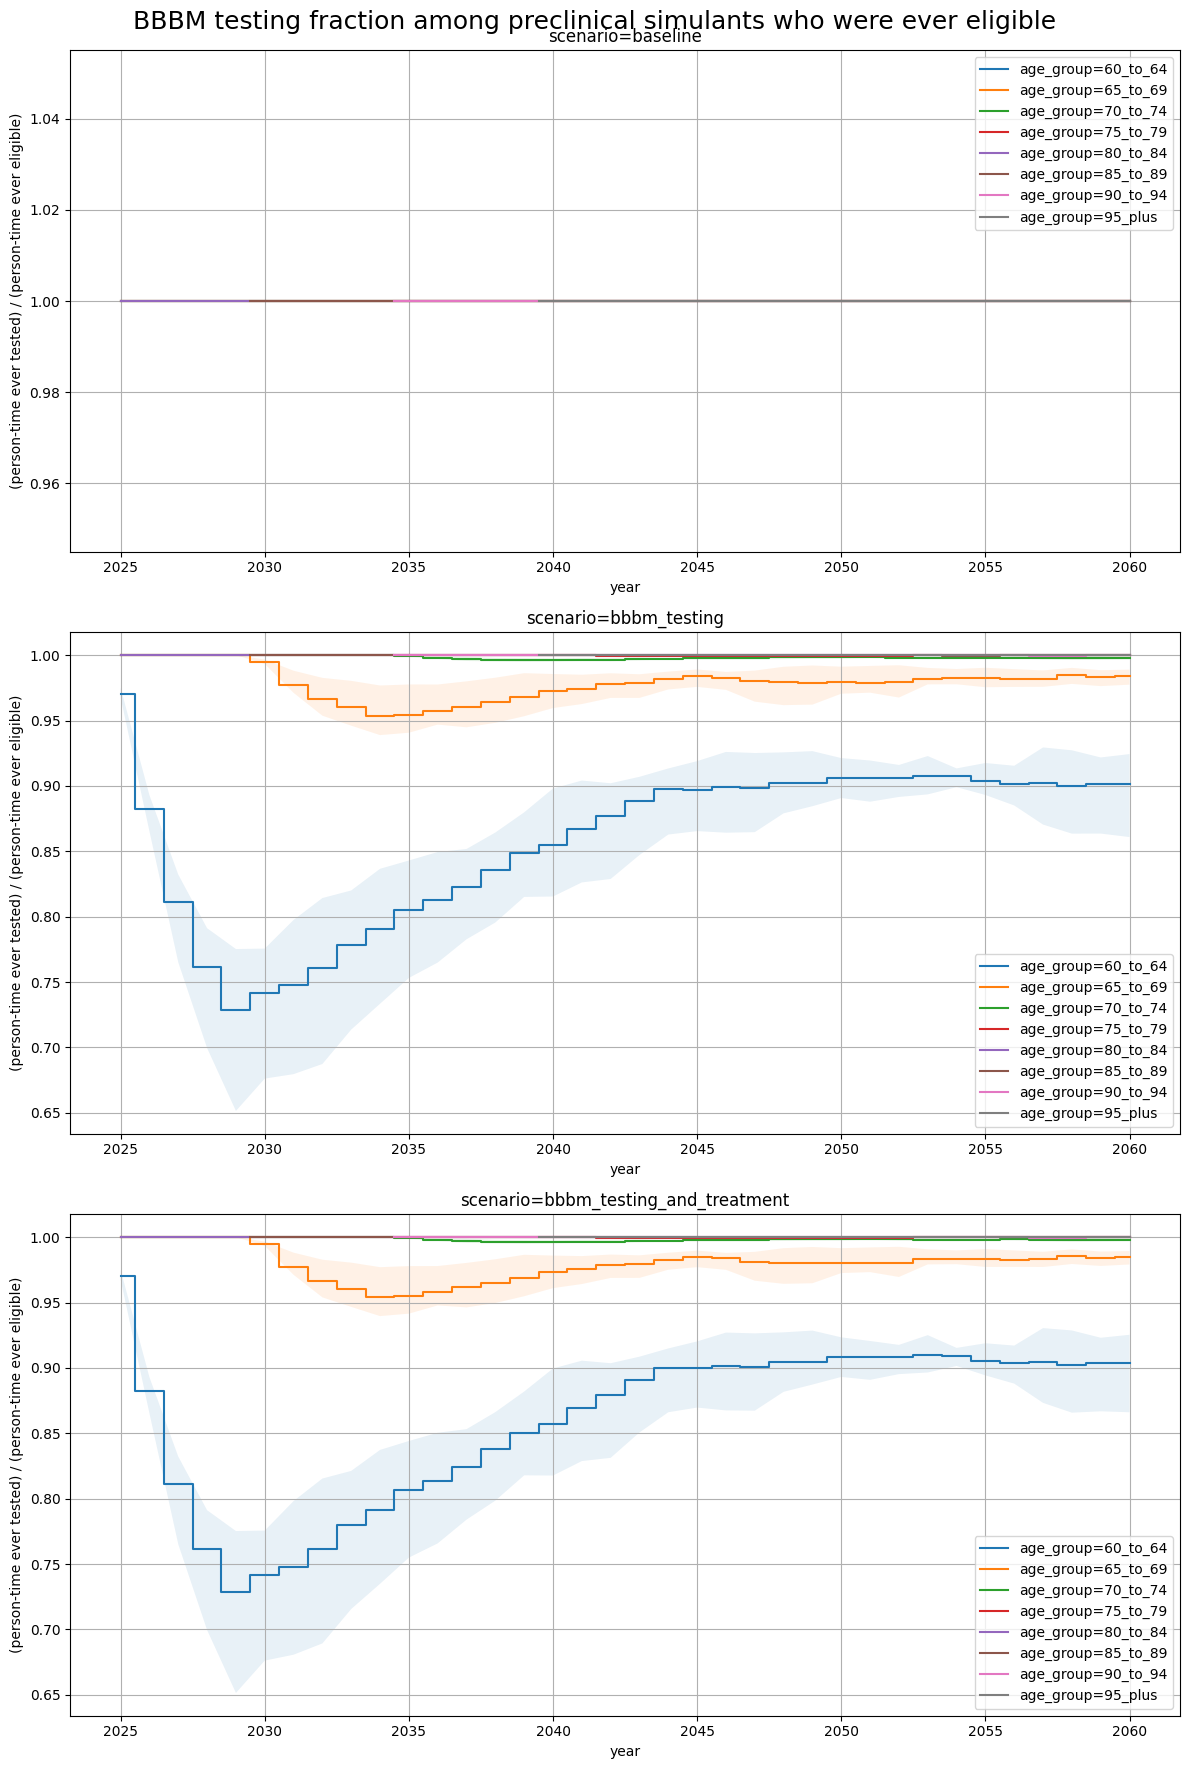

In [62]:
location = locations[5]
print(location)
# NOTE: I got "ValueError: unknown type object" when calling 
# .query("age_group < '60_to_64'") -- I fixed this by converting the
# dtype from Categorical to string. Using .loc doesn't work either
# because you can't compare unordered Categoricals. If we used an
# ordered Categorical for the age groups, that might make this easier.
# fig, ax = plt.subplots(figsize=(12, 6))
fig = plot_over_time_by_column_for_row_x_1(
    ever_tested_over_ever_eligible.astype({'age_group': str})
        .query("age_group >= '60_to_64' and location==@location"),
        #.loc[ever_tested_over_ever_eligible.age_group < '60_to_64'],
        # .query("age_group in ['60_to_64', '65_to_69', '70_to_74', '75_to_79']"),
    'age_group',
    'scenario',
    # ax=ax,
    ylabel='(person-time ever tested) / (person-time ever eligible)',
    suptitle='BBBM testing fraction among preclinical simulants who were ever eligible',
    # plot_func='step',
    # where='post',
    ds='steps-mid',
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::5])
    ax.grid(True)
plt.show()


## Try to investigate why the ratio is 1.0 for some age groups...

In [63]:
temp = ever_tested_over_ever_eligible.query("value==1.0 and scenario=='bbbm_testing'")
print(temp.age_group.unique())
temp

['65_to_69', '70_to_74', '75_to_79', '80_to_84', '85_to_89', '90_to_94', '95_plus']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']


event_year age_group input_draw      scenario  \
1210         2025  65_to_69        392  bbbm_testing   
1211         2025  65_to_69        392  bbbm_testing   
1212         2025  65_to_69        392  bbbm_testing   
1213         2025  65_to_69        392  bbbm_testing   
1214         2025  65_to_69        392  bbbm_testing   
...           ...       ...        ...           ...   
80985        2060   95_plus        346  bbbm_testing   
80986        2060   95_plus        346  bbbm_testing   
80987        2060   95_plus        346  bbbm_testing   
80988        2060   95_plus        346  bbbm_testing   
80989        2060   95_plus        346  bbbm_testing   

                         location  value  \
1210                       Brazil    1.0   
1211                        China    1.0   
1212                      Germany    1.0   
1213                       Israel    1.0   
1214                        Japan    1.0   
...                           ...    ...   
80985                       Spain    1.0   
80986                      Sweden    1.0   
80987  Taiwan (Province of China)    1.0   
80988              United Kingdom    1.0   
80989    United States of America    1.0   

                                numerator_measure  \
1210   person_time_ever_eligible_for_bbbm_testing   
1211   person_time_ever_eligible_for_bbbm_testing   
1212   person_time_ever_eligible_for_bbbm_testing   
1213   person_time_ever_eligible_for_bbbm_testing   
1214   person_time_ever_eligible_for_bbbm_testing   
...                                           ...   
80985  person_time_ever_eligible_for_bbbm_testing   
80986  person_time_ever_eligible_for_bbbm_testing   
80987  person_time_ever_eligible_for_bbbm_testing   
80988  person_time_ever_eligible_for_bbbm_testing   
80989  person_time_ever_eligible_for_bbbm_testing   

                              denominator_measure  multiplier  
1210   person_time_ever_eligible_for_bbbm_testing           1  
1211   person_time_ever_eligible_for_bbbm_testing           1  
1212   person_time_ever_eligible_for_bbbm_testing           1  
1213   person_time_ever_eligible_for_bbbm_testing           1  
1214   person_time_ever_eligible_for_bbbm_testing           1  
...                                           ...         ...  
80985  person_time_ever_eligible_for_bbbm_testing           1  
80986  person_time_ever_eligible_for_bbbm_testing           1  
80987  person_time_ever_eligible_for_bbbm_testing           1  
80988  person_time_ever_eligible_for_bbbm_testing           1  
80989  person_time_ever_eligible_for_bbbm_testing           1  

[6582 rows x 9 columns]

In [64]:
temp = pt_ever_eligible_bbbm.query(
    "scenario=='bbbm_testing' and age_group=='80_to_84'"
    " and alzheimers_disease_and_other_dementias == 'alzheimers_blood_based_biomarker_state'"
)
temp

age_group  alzheimers_disease_and_other_dementias  \
1069202  80_to_84  alzheimers_blood_based_biomarker_state   
1069203  80_to_84  alzheimers_blood_based_biomarker_state   
1069208  80_to_84  alzheimers_blood_based_biomarker_state   
1069209  80_to_84  alzheimers_blood_based_biomarker_state   
1069214  80_to_84  alzheimers_blood_based_biomarker_state   
...           ...                                     ...   
1101585  80_to_84  alzheimers_blood_based_biomarker_state   
1101590  80_to_84  alzheimers_blood_based_biomarker_state   
1101591  80_to_84  alzheimers_blood_based_biomarker_state   
1101596  80_to_84  alzheimers_blood_based_biomarker_state   
1101597  80_to_84  alzheimers_blood_based_biomarker_state   

                                             artifact_path bbbm_test_results  \
1069202  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1069203  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1069208  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1069209  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1069214  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
...                                                    ...               ...   
1101585  /mnt/team/simulation_science/pub/models/vivari...          negative   
1101590  /mnt/team/simulation_science/pub/models/vivari...          negative   
1101591  /mnt/team/simulation_science/pub/models/vivari...          negative   
1101596  /mnt/team/simulation_science/pub/models/vivari...          negative   
1101597  /mnt/team/simulation_science/pub/models/vivari...          negative   

               entity entity_type  event_year input_draw  \
1069202  bbbm_testing     testing        2025        392   
1069203  bbbm_testing     testing        2025        392   
1069208  bbbm_testing     testing        2025        169   
1069209  bbbm_testing     testing        2025        169   
1069214  bbbm_testing     testing        2025        457   
...               ...         ...         ...        ...   
1101585  bbbm_testing     testing        2060        457   
1101590  bbbm_testing     testing        2060        323   
1101591  bbbm_testing     testing        2060        323   
1101596  bbbm_testing     testing        2060        346   
1101597  bbbm_testing     testing        2060        346   

                                            measure      scenario     sex  \
1069202  person_time_ever_eligible_for_bbbm_testing  bbbm_testing  Female   
1069203  person_time_ever_eligible_for_bbbm_testing  bbbm_testing    Male   
1069208  person_time_ever_eligible_for_bbbm_testing  bbbm_testing  Female   
1069209  person_time_ever_eligible_for_bbbm_testing  bbbm_testing    Male   
1069214  person_time_ever_eligible_for_bbbm_testing  bbbm_testing  Female   
...                                             ...           ...     ...   
1101585  person_time_ever_eligible_for_bbbm_testing  bbbm_testing    Male   
1101590  person_time_ever_eligible_for_bbbm_testing  bbbm_testing  Female   
1101591  person_time_ever_eligible_for_bbbm_testing  bbbm_testing    Male   
1101596  person_time_ever_eligible_for_bbbm_testing  bbbm_testing  Female   
1101597  person_time_ever_eligible_for_bbbm_testing  bbbm_testing    Male   

               value location  
1069202     0.000000    Japan  
1069203     0.000000    Japan  
1069208     0.000000    Japan  
1069209     0.000000    Japan  
1069214     0.000000    Japan  
...              ...      ...  
1101585  2255.255305    China  
1101590  4371.986311    China  
1101591  1682.721424    China  
1101596  2706.206708    China  
1101597  1366.806297    China  

[10800 rows x 13 columns]

In [65]:
temp.query("bbbm_test_results=='not_tested'")

age_group  alzheimers_disease_and_other_dementias  \
1069202  80_to_84  alzheimers_blood_based_biomarker_state   
1069203  80_to_84  alzheimers_blood_based_biomarker_state   
1069208  80_to_84  alzheimers_blood_based_biomarker_state   
1069209  80_to_84  alzheimers_blood_based_biomarker_state   
1069214  80_to_84  alzheimers_blood_based_biomarker_state   
...           ...                                     ...   
1099425  80_to_84  alzheimers_blood_based_biomarker_state   
1099430  80_to_84  alzheimers_blood_based_biomarker_state   
1099431  80_to_84  alzheimers_blood_based_biomarker_state   
1099436  80_to_84  alzheimers_blood_based_biomarker_state   
1099437  80_to_84  alzheimers_blood_based_biomarker_state   

                                             artifact_path bbbm_test_results  \
1069202  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1069203  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1069208  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1069209  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1069214  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
...                                                    ...               ...   
1099425  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1099430  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1099431  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1099436  /mnt/team/simulation_science/pub/models/vivari...        not_tested   
1099437  /mnt/team/simulation_science/pub/models/vivari...        not_tested   

               entity entity_type  event_year input_draw  \
1069202  bbbm_testing     testing        2025        392   
1069203  bbbm_testing     testing        2025        392   
1069208  bbbm_testing     testing        2025        169   
1069209  bbbm_testing     testing        2025        169   
1069214  bbbm_testing     testing        2025        457   
...               ...         ...         ...        ...   
1099425  bbbm_testing     testing        2060        457   
1099430  bbbm_testing     testing        2060        323   
1099431  bbbm_testing     testing        2060        323   
1099436  bbbm_testing     testing        2060        346   
1099437  bbbm_testing     testing        2060        346   

                                            measure      scenario     sex  \
1069202  person_time_ever_eligible_for_bbbm_testing  bbbm_testing  Female   
1069203  person_time_ever_eligible_for_bbbm_testing  bbbm_testing    Male   
1069208  person_time_ever_eligible_for_bbbm_testing  bbbm_testing  Female   
1069209  person_time_ever_eligible_for_bbbm_testing  bbbm_testing    Male   
1069214  person_time_ever_eligible_for_bbbm_testing  bbbm_testing  Female   
...                                             ...           ...     ...   
1099425  person_time_ever_eligible_for_bbbm_testing  bbbm_testing    Male   
1099430  person_time_ever_eligible_for_bbbm_testing  bbbm_testing  Female   
1099431  person_time_ever_eligible_for_bbbm_testing  bbbm_testing    Male   
1099436  person_time_ever_eligible_for_bbbm_testing  bbbm_testing  Female   
1099437  person_time_ever_eligible_for_bbbm_testing  bbbm_testing    Male   

            value location  
1069202  0.000000    Japan  
1069203  0.000000    Japan  
1069208  0.000000    Japan  
1069209  0.000000    Japan  
1069214  0.000000    Japan  
...           ...      ...  
1099425  0.000000    China  
1099430  0.000000    China  
1099431  0.498289    China  
1099436  0.000000    China  
1099437  0.000000    China  

[3600 rows x 13 columns]